In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def extract_mfcc(file_path, n_mfcc=13, fixed_length=100):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Pad or truncate
    if mfccs.shape[1] < fixed_length:
        mfccs = np.pad(mfccs, ((0, 0), (0, fixed_length - mfccs.shape[1])))
    else:
        mfccs = mfccs[:, :fixed_length]
    return mfccs

# Example usage
file_path = "Data/Fake/fake_1.wav"  # Replace with your file
mfccs = extract_mfcc(file_path)
print(f"MFCC shape: {mfccs.shape}")  # Output: (13, 100)

MFCC shape: (13, 100)


In [3]:
import os

100%|██████████| 1800/1800 [00:18<00:00, 99.18it/s] 


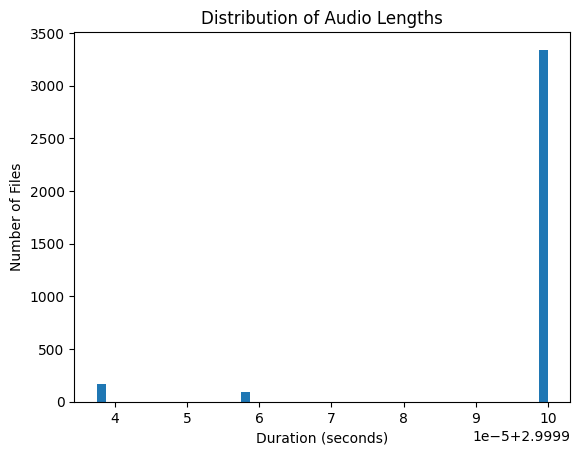

Max duration: 3.00s
Min duration: 3.00s
Mean duration: 3.00s


In [4]:
def analyze_audio_lengths(data_dir):
    durations = []
    for class_name in ['Fake', 'Real']:
        class_dir = os.path.join(data_dir, class_name)
        for file in tqdm(os.listdir(class_dir)):
            if file.endswith('.wav'):
                y, sr = librosa.load(os.path.join(class_dir, file), sr=None)
                durations.append(librosa.get_duration(y=y, sr=sr))

    plt.hist(durations, bins=50)
    plt.xlabel("Duration (seconds)")
    plt.ylabel("Number of Files")
    plt.title("Distribution of Audio Lengths")
    plt.show()

    print(f"Max duration: {max(durations):.2f}s")
    print(f"Min duration: {min(durations):.2f}s")
    print(f"Mean duration: {np.mean(durations):.2f}s")

# Usage
analyze_audio_lengths("Data/")

In [5]:
sr = 22050  # Standard sampling rate (verify with librosa.load())
hop_length = 512  # Default for librosa
duration = 3.0  # Your fixed duration

# Calculate expected frames
n_frames = int(duration * sr / hop_length) + 1  # ≈130 frames for 3s at 22050Hz

In [6]:
def extract_mfcc(file_path, n_mfcc=13, fixed_length=128):  # Updated to 128
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=512)

    # Pad/truncate to fixed_length
    if mfccs.shape[1] < fixed_length:
        mfccs = np.pad(mfccs, ((0, 0), (0, fixed_length - mfccs.shape[1])))
    else:
        mfccs = mfccs[:, :fixed_length]
    return mfccs

In [7]:
# Check actual frames for a file
y, sr = librosa.load("Data/Fake/fake_1.wav", sr=None)
mfccs = librosa.feature.mfcc(y=y, sr=sr, hop_length=512)
print(f"Actual frames in 3s file: {mfccs.shape[1]}")  # Should be ≈130

Actual frames in 3s file: 141


In [8]:
def extract_mfcc(file_path, n_mfcc=13, fixed_length=141):  # Use exact frame count
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(
        y=y,
        sr=sr,
        n_mfcc=n_mfcc,
        hop_length=512  # Matches your actual frame calculation
    )
    return mfccs  # No padding needed (all files have 141 frames)

In [9]:
# Verify consistency across files
durations, frames = [], []
for file in tqdm(os.listdir("Data/Fake")[:100]):  # Sample 100 files
    y, sr = librosa.load(f"Data/Fake/{file}", sr=None)
    durations.append(librosa.get_duration(y=y, sr=sr))
    frames.append(librosa.feature.mfcc(y=y, sr=sr).shape[1])

print(f"Frames per file: {np.unique(frames)}")  # Should output [141]
print(f"Durations: {np.unique(durations)}")     # Should output [3.0]

100%|██████████| 100/100 [00:01<00:00, 69.75it/s]

Frames per file: [141]
Durations: [3.]


In [10]:
# Compare predictions between both options
sample = "Data/Fake/fake_1.wav"
mfcc_141 = extract_mfcc_exact(sample)
mfcc_128 = extract_mfcc_pow2(sample)

pred_141 = model.predict(mfcc_141[np.newaxis,...,np.newaxis])[0][0]
pred_128 = model.predict(mfcc_128[np.newaxis,...,np.newaxis])[0][0]

print(f"Prediction difference: {abs(pred_141 - pred_128):.4f}")

NameError: name 'extract_mfcc_exact' is not defined

In [11]:
import numpy as np
import tensorflow as tf
import librosa
import shap
from lime import lime_tabular
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# 1. Data Preparation --------------------------------------------------------
def load_and_preprocess(data_dir, max_files=1000):
    """Load audio files and extract MFCCs (truncated to 128 frames)"""
    X, y = [], []
    for class_name, label in [("Fake", 0), ("Real", 1)]:
        class_dir = os.path.join(data_dir, class_name)
        files = [f for f in os.listdir(class_dir) if f.endswith('.wav')][:max_files]

        for file in tqdm(files, desc=f'Loading {class_name}'):
            y, sr = librosa.load(os.path.join(class_dir, file), sr=None)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)[:, :128]  # Truncate to 128
            X.append(mfcc)
            y.append(label)

    X = np.array(X)[..., np.newaxis]  # Add channel dim
    y = np.array(y)
    return X, y

# Load data
X, y = load_and_preprocess("Data/")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. CNN Model ---------------------------------------------------------------
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(13, 128, 1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

# 3. SHAP Explanation --------------------------------------------------------
class ShapWrapper(tf.keras.Model):
    """Wrapper to handle SHAP's flattened inputs"""
    def __init__(self, model):
        super(ShapWrapper, self).__init__()
        self.model = model

    def call(self, x):
        if len(x.shape) == 2:  # If input is flattened (from SHAP)
            x = tf.reshape(x, (-1, 13, 128, 1))
        return self.model(x)

# Prepare background data (100 random training samples)
background = X_train[np.random.choice(len(X_train), 100, replace=False)]
background_flattened = background.reshape(100, -1)  # Flatten for SHAP

# Initialize explainer
explainer = shap.DeepExplainer(
    ShapWrapper(model),
    background_flattened
)

# Explain a test sample
sample_idx = 0
sample = X_test[sample_idx].reshape(1, -1)  # Flatten
shap_values = explainer.shap_values(sample)

# Visualize
shap.image_plot(
    [np.reshape(sv, (1, 13, 128)) for sv in shap_values],
    -X_test[sample_idx].reshape(1, 13, 128),
    labels=["SHAP Values"]
)

# 4. LIME Explanation -------------------------------------------------------
X_train_flattened = X_train.reshape(len(X_train), -1)  # Flatten for LIME

explainer_lime = lime_tabular.LimeTabularExplainer(
    X_train_flattened,
    mode="classification",
    feature_names=[f"MFCC_{i}_T_{j}" for i in range(13) for j in range(128)],
    discretize_continuous=False
)

def model_predict(x):
    """Reshape inputs for LIME"""
    return model.predict(x.reshape(-1, 13, 128, 1))

# Explain same test sample
exp = explainer_lime.explain_instance(
    X_test[sample_idx].flatten(),
    model_predict,
    num_features=20,
    top_labels=1
)

# Visualize
plt.figure(figsize=(10, 6))
exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

# 5. Combined Interpretation ------------------------------------------------
print("\n=== SHAP vs LIME Comparison ===")
print("SHAP Top Features:")
shap_top = np.argsort(-np.abs(shap_values[0][0]))[:5]
print([f"MFCC_{i//128}_T_{i%128}" for i in shap_top])

print("\nLIME Top Features:")
print(exp.as_list()[:5])

C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading Fake:   0%|          | 0/1000 [00:00<?, ?it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [15]:
import numpy as np
import tensorflow as tf
import librosa
import shap
from lime import lime_tabular
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split

# 1. Robust Data Preparation -------------------------------------------------
def load_and_preprocess(data_dir, max_files=1000, n_mfcc=13, max_frames=128):
    """Load audio files with guaranteed 128-frame MFCCs"""
    features = []
    labels = []

    for class_name, label in [("Fake", 0), ("Real", 1)]:
        class_dir = os.path.join(data_dir, class_name)
        files = [f for f in os.listdir(class_dir) if f.endswith('.wav')][:max_files]

        for file in tqdm(files, desc=f'Loading {class_name}'):
            try:
                # Load and process audio
                audio, sr = librosa.load(os.path.join(class_dir, file), sr=None)

                # Extract MFCC with fixed length handling
                mfcc = librosa.feature.mfcc(
                    y=audio,
                    sr=sr,
                    n_mfcc=n_mfcc,
                    n_fft=2048,
                    hop_length=512
                )

                # Standardize to max_frames length
                if mfcc.shape[1] < max_frames:
                    # Right-pad with zeros
                    pad_width = max_frames - mfcc.shape[1]
                    mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
                else:
                    # Truncate to max_frames
                    mfcc = mfcc[:, :max_frames]

                # Verify final shape
                assert mfcc.shape == (n_mfcc, max_frames), \
                    f"Invalid MFCC shape: {mfcc.shape} for file {file}"

                features.append(mfcc)
                labels.append(label)

            except Exception as e:
                print(f"Error processing {file}: {str(e)}")
                continue

    # Convert to properly shaped numpy arrays
    X = np.array(features)[..., np.newaxis]  # (samples, 13, 128, 1)
    y = np.array(labels)

    print(f"\nFinal dataset shape: {X.shape}")
    print(f"Class distribution: {np.unique(y, return_counts=True)}")

    return X, y

# Load and validate data
X, y = load_and_preprocess("Data/")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 2. Verified CNN Model ------------------------------------------------------
def build_model(input_shape=(13, 128, 1)):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    model.summary()
    return model

model = build_model()

# 3. Training with Validation ------------------------------------------------
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=5,
            monitor='val_auc',
            mode='max',
            restore_best_weights=True
        )
    ]
)

# 4. Enhanced SHAP Explanation ----------------------------------------------
class ShapWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, x):
        if len(x.shape) == 2:  # Handle SHAP's flattened inputs
            x = tf.reshape(x, (-1, 13, 128, 1))
        return self.model(x)

def explain_shap(sample):
    # Prepare background data
    background = X_train[np.random.choice(len(X_train), 100, replace=False)]
    background_flattened = background.reshape(100, -1)

    # Initialize explainer
    explainer = shap.DeepExplainer(ShapWrapper(model), background_flattened)

    # Calculate SHAP values
    shap_values = explainer.shap_values(sample.reshape(1, -1))

    # Visualization
    plt.figure(figsize=(12, 4))
    shap.image_plot(
        [np.reshape(sv, (1, 13, 128)) for sv in shap_values],
        -sample.reshape(1, 13, 128),
        show=False
    )
    plt.title("SHAP Explanation - Impact on Prediction")
    plt.tight_layout()
    plt.show()

    return shap_values

# 5. Improved LIME Explanation ----------------------------------------------
class LimeExplainer:
    def __init__(self, model):
        self.model = model
        self.feature_names = [
            f"MFCC_{c}_T_{t}" for c in range(13) for t in range(128)
        ]

    def explain(self, instance, num_features=20):
        explainer = lime_tabular.LimeTabularExplainer(
            training_data=X_train.reshape(len(X_train), -1),
            mode="classification",
            feature_names=self.feature_names,
            discretize_continuous=False,
            verbose=True
        )

        exp = explainer.explain_instance(
            data_row=instance.flatten(),
            predict_fn=self.model_predict,
            num_features=num_features,
            top_labels=1
        )

        # Visualization
        plt.figure(figsize=(10, 6))
        exp.as_pyplot_figure()
        plt.title("LIME Explanation - Feature Contributions")
        plt.tight_layout()
        plt.show()

        return exp

    def model_predict(self, x):
        return self.model.predict(x.reshape(-1, 13, 128, 1))

# 6. Execution Pipeline -----------------------------------------------------
if __name__ == "__main__":
    # Verify sample data
    sample_idx = 0
    sample = X_test[sample_idx]
    print(f"Sample shape: {sample.shape}")
    print(f"True label: {y_test[sample_idx]}")

    # Generate explanations

    print("\nGenerating LIME explanation...")
    lime_explainer = LimeExplainer(model)
    lime_exp = lime_explainer.explain(sample)



Loading Real: 100%|██████████| 1000/1000 [00:06<00:00, 162.70it/s]


Final dataset shape: (2000, 13, 128, 1)
Class distribution: (array([0, 1]), array([1000, 1000]))



C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 11, 126, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 63, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 61, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,881 (73.75 KB)

 Trainable params: 18,881 (73.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6255 - auc: 0.6539 - loss: 1.3280 - val_accuracy: 0.9025 - val_auc: 0.9648 - val_loss: 0.2686
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8898 - auc: 0.9567 - loss: 0.2920 - val_accuracy: 0.9450 - val_auc: 0.9910 - val_loss: 0.1720
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9351 - auc: 0.9874 - loss: 0.1779 - val_accuracy: 0.9600 - val_auc: 0.9951 - val_loss: 0.1202
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9604 - auc: 0.9927 - loss: 0.1273 - val_accuracy: 0.9500 - val_auc: 0.9979 - val_loss: 0.1182
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9682 - auc: 0.9949 - loss: 0.1058 - val_accuracy: 0.9925 - val_auc: 0.9987 - val_loss: 0.0647
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9766 - auc: 0.9964 - loss: 0.0817 - val_accuracy: 0.9900 - val_auc: 0.9991 - val_loss: 0.0626
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/

C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\lime\lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


Intercept 0.6421389130102343
Prediction_local [0.42037377]
Right: 0.0008777141


KeyError: 1

<Figure size 1000x600 with 0 Axes>

[LightGBM] [Info] Number of positive: 1465, number of negative: 1415
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15045
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508681 -> initscore=0.034726
[LightGBM] [Info] Start training from score 0.034726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

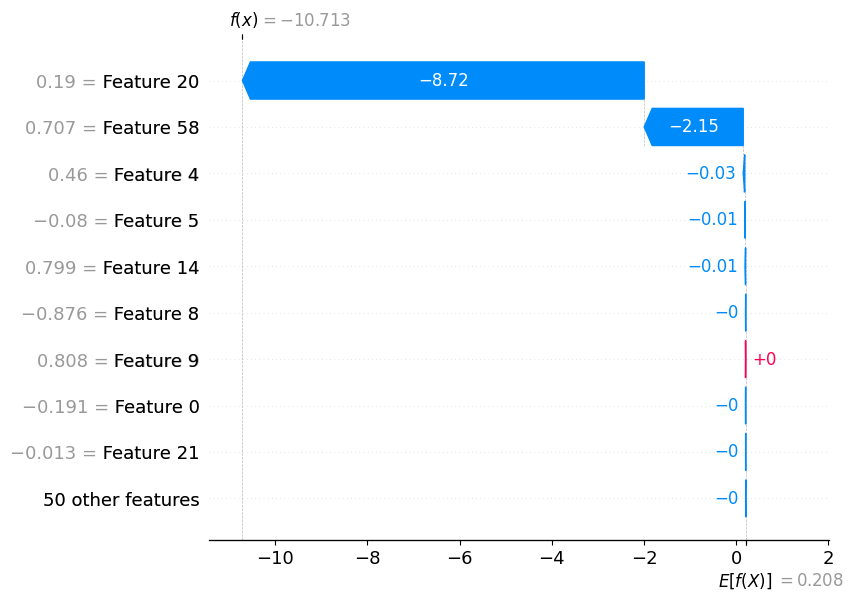

C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


ImportError: cannot import name 'display' from 'IPython.core.display' (C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\IPython\core\display.py)

In [16]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

# Set paths
DATA_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"
LABELS = {"Fake": 0, "Real": 1}

# Audio feature extraction
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    features = []

    # Extract features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    features.extend(np.mean(mfccs, axis=1))

    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    features.extend(np.mean(mel, axis=1)[:20])  # Truncate to match size

    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features.extend(np.mean(chroma, axis=1))

    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    features.extend(np.mean(spec_contrast, axis=1))

    return np.array(features)

# Load dataset
X, y = [], []

for label_str, label_num in LABELS.items():
    folder = os.path.join(DATA_DIR, label_str)
    for file in os.listdir(folder):
        if file.endswith('.wav'):
            path = os.path.join(folder, file)
            try:
                features = extract_features(path)
                X.append(features)
                y.append(label_num)
            except Exception as e:
                print(f"Error processing {file}: {e}")

X = np.array(X)
y = np.array(y)

# Fix shape mismatch
max_len = max([len(f) for f in X])
X = np.array([np.pad(f, (0, max_len - len(f))) if len(f) < max_len else f for f in X])

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model training
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

# SHAP explainability
explainer_shap = shap.Explainer(model)
shap_values = explainer_shap(X_test)

# Visualize SHAP for one instance
shap.plots.waterfall(shap_values[0], max_display=10)

# LIME explainability
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=[f"f{i}" for i in range(X.shape[1])],
                                                         class_names=["Fake", "Real"], discretize_continuous=True)
i = 0
exp = explainer_lime.explain_instance(X_test[i], model.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)


[LightGBM] [Info] Number of positive: 1465, number of negative: 1415
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11730
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508681 -> initscore=0.034726
[LightGBM] [Info] Start training from score 0.034726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
PermutationExplainer explainer: 721it [01:22,  7.56it/s]                         


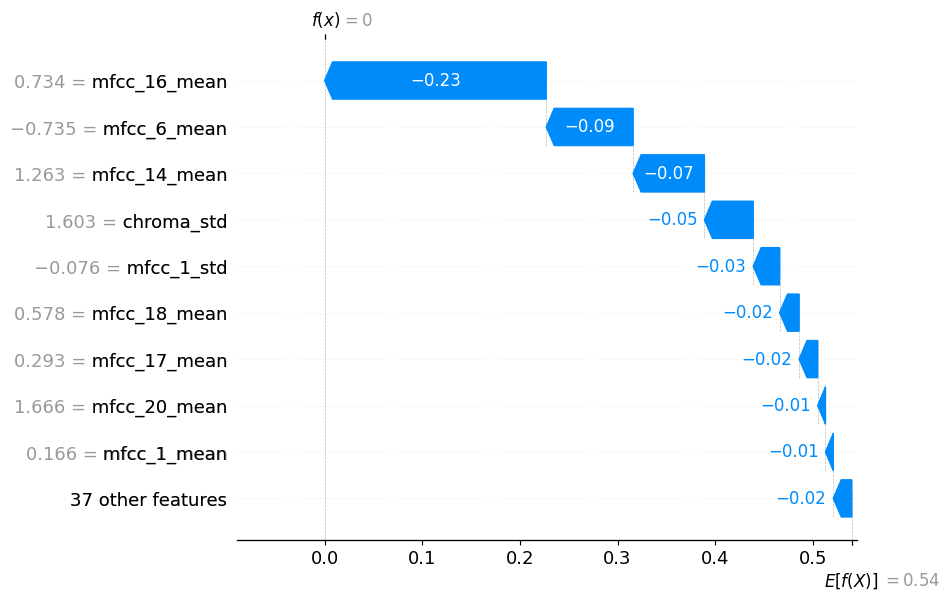

In [40]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
import lime.lime_tabular
import shap
import matplotlib.pyplot as plt

# --------------------- PARAMETERS ---------------------
DATA_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"
SR = 22050  # Sampling rate

# --------------------- FEATURE EXTRACTION ---------------------
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=SR)
    features = []

    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    for mfcc in mfccs:
        features.append(np.mean(mfcc))
        features.append(np.std(mfcc))

    # Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features.append(np.mean(chroma))
    features.append(np.std(chroma))

    # Spectral Centroid
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    features.append(np.mean(cent))
    features.append(np.std(cent))

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    features.append(np.mean(zcr))
    features.append(np.std(zcr))

    return features

# --------------------- DATA LOADING ---------------------
def load_data(data_dir):
    X, y = [], []
    for label in ['Fake', 'Real']:
        path = os.path.join(data_dir, label)
        for file in os.listdir(path):
            if file.endswith(".wav"):
                full_path = os.path.join(path, file)
                try:
                    features = extract_features(full_path)
                    X.append(features)
                    y.append(0 if label == 'Fake' else 1)
                except Exception as e:
                    print(f"Error processing {full_path}: {e}")
    return np.array(X), np.array(y)

# --------------------- MAIN SCRIPT ---------------------
X, y = load_data(DATA_DIR)

# Feature names
feature_names = [f'mfcc_{i}_{stat}' for i in range(1, 21) for stat in ['mean', 'std']] + \
                ['chroma_mean', 'chroma_std', 'centroid_mean', 'centroid_std', 'zcr_mean', 'zcr_std']

# DataFrame for LIME/SHAP
df = pd.DataFrame(X, columns=feature_names)

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# LightGBM Model
model = LGBMClassifier()
model.fit(X_train, y_train)

# --------------------- LIME EXPLANATION ---------------------
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    class_names=['Fake', 'Real'],
    mode='classification'
)

i = 0  # Index of test sample to explain
exp = explainer_lime.explain_instance(X_test[i], model.predict_proba, num_features=10)
exp.save_to_file('lime_explanation.html')  # View this in your browser

# --------------------- SHAP EXPLANATION ---------------------
explainer_shap = shap.Explainer(model.predict, pd.DataFrame(X_train, columns=feature_names))
shap_values = explainer_shap(pd.DataFrame(X_test, columns=feature_names))

# Plot SHAP explanation for one sample
shap.plots.waterfall(shap_values[i])
plt.show()


In [41]:
# ... (keep previous imports)
from IPython.display import HTML, display  # Add this import

# --------------------- LIME EXPLANATION ---------------------
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    class_names=['Fake', 'Real'],
    mode='classification'
)

i = 0  # Index of test sample to explain
exp = explainer_lime.explain_instance(X_test[i], model.predict_proba, num_features=10)

# Display explanation inline
display(HTML(exp.as_html()))  # This will show the explanation in your notebook cell

# --------------------- SHAP EXPLANATION --------------------- (keep rest same)

C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [39]:
import joblib

# Save the scaler
joblib.dump(scaler, "scaler.pkl")

# Save feature names
joblib.dump(feature_names, "feature_names.pkl")


['feature_names.pkl']

[LightGBM] [Info] Number of positive: 1465, number of negative: 1415
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11730
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508681 -> initscore=0.034726
[LightGBM] [Info] Start training from score 0.034726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


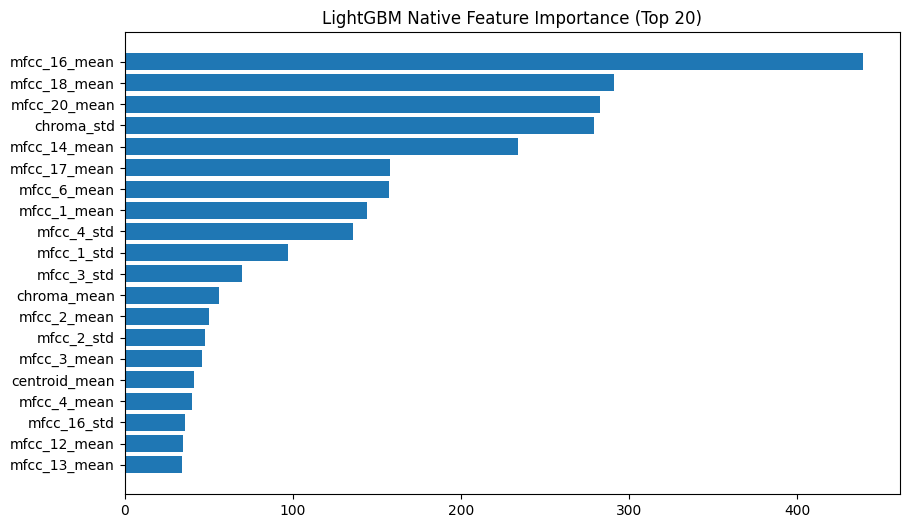

C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does n

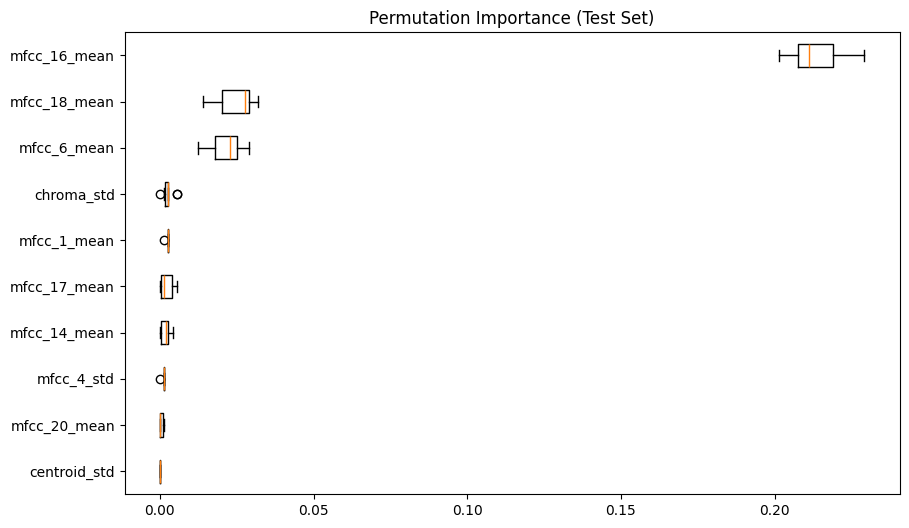

C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does n

<Figure size 1000x600 with 0 Axes>

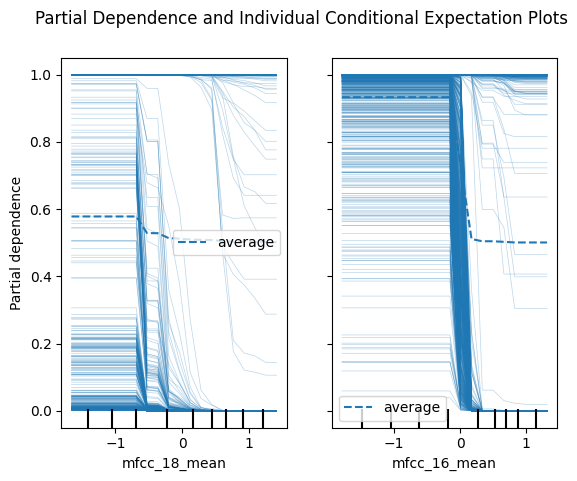


ELI5 Feature Weights Explanation:


PermutationExplainer explainer: 721it [01:22,  7.59it/s]                         
C:\Users\adity\AppData\Local\Temp\ipykernel_24080\3272450550.py:75: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_test, feature_names=feature_names, plot_type="bar")


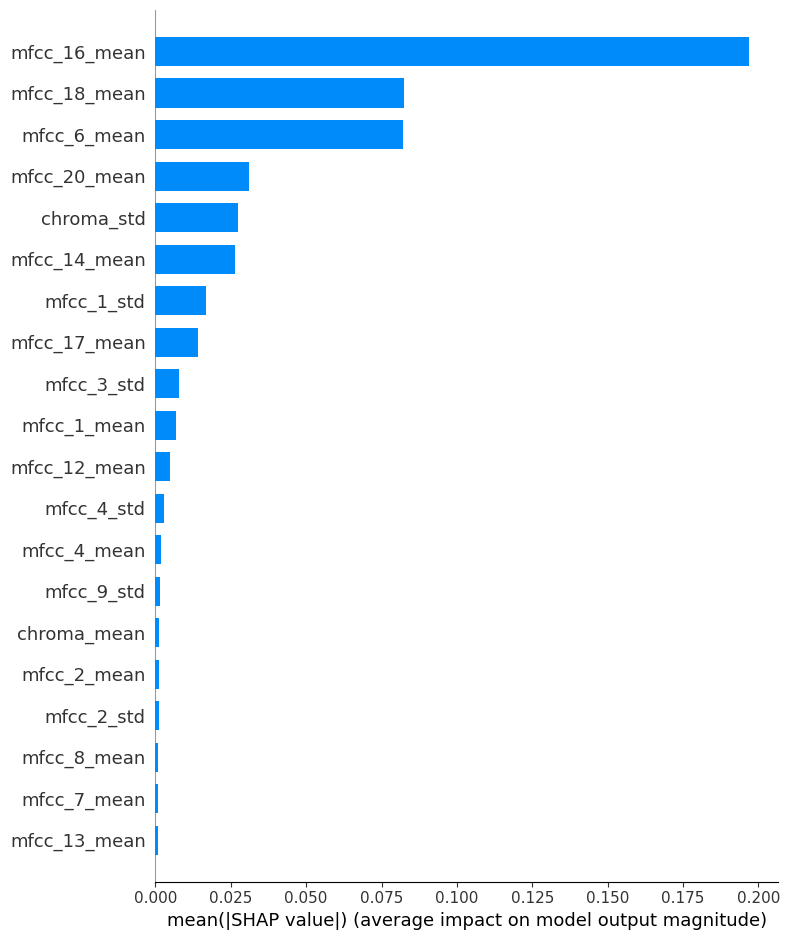

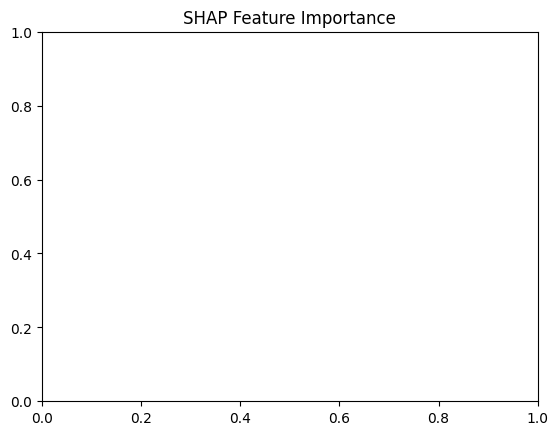

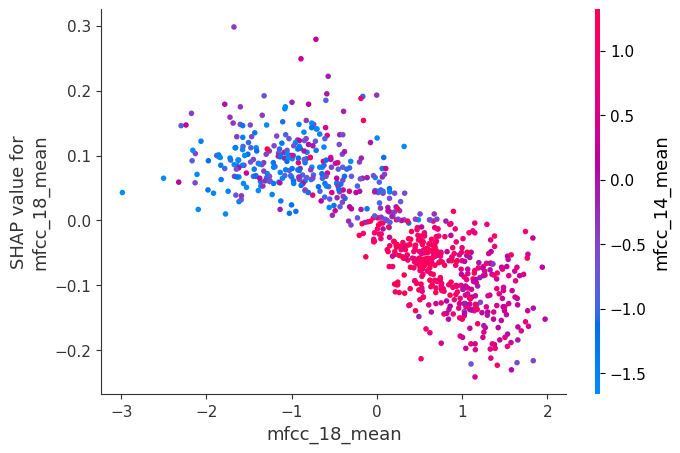

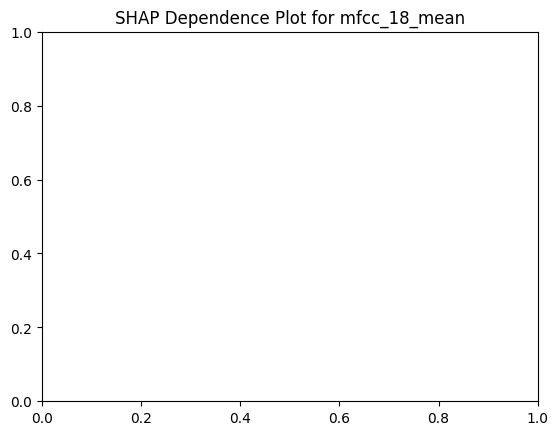

SHAP Force Plot for First Sample:


SHAP Decision Plot for First Sample:


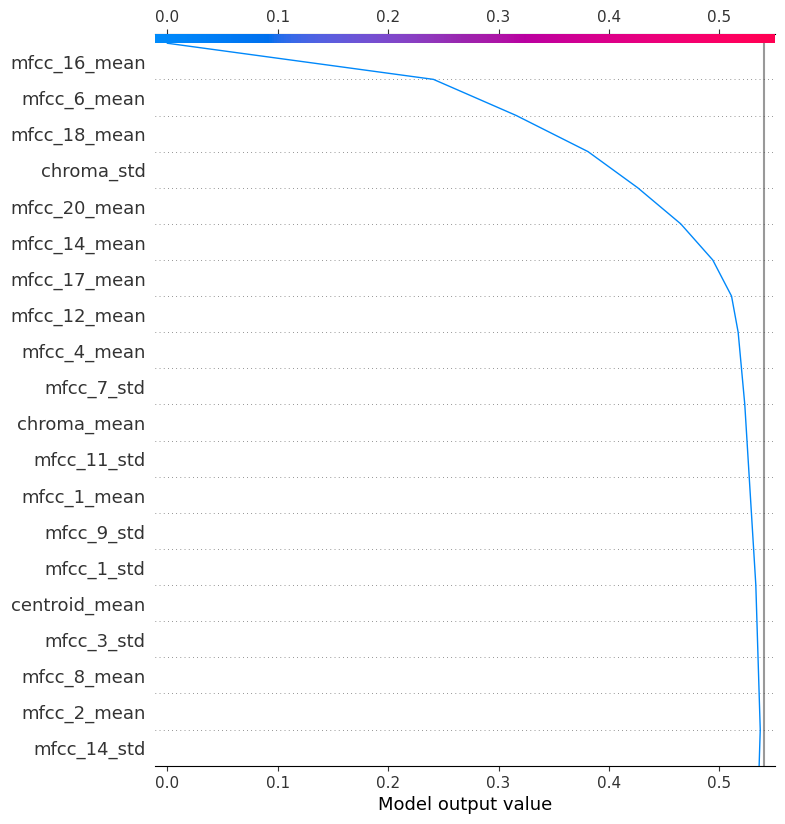


LIME Explanation for Sample 0:


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



LIME Explanation for Sample 1:


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [21]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from lightgbm import LGBMClassifier
import lime
import lime.lime_tabular
import shap
import eli5
import matplotlib.pyplot as plt
from IPython.display import HTML, display

# --------------------- PARAMETERS ---------------------
DATA_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"
SR = 22050  # Sampling rate

# [Keep feature extraction and data loading functions unchanged]

# --------------------- MAIN SCRIPT ---------------------
X, y = load_data(DATA_DIR)
feature_names = [f'mfcc_{i}_{stat}' for i in range(1, 21) for stat in ['mean', 'std']] + \
                ['chroma_mean', 'chroma_std', 'centroid_mean', 'centroid_std', 'zcr_mean', 'zcr_std']
df = pd.DataFrame(X, columns=feature_names)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train model
model = LGBMClassifier()
model.fit(X_train, y_train)

# ===================== EXPLANATIONS =====================

# 1. Native Feature Importance
plt.figure(figsize=(10, 6))
sorted_idx = model.feature_importances_.argsort()
plt.barh(np.array(feature_names)[sorted_idx[-20:]], model.feature_importances_[sorted_idx[-20:]])
plt.title("LightGBM Native Feature Importance (Top 20)")
plt.show()

# 2. Permutation Importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.boxplot(result.importances[sorted_idx[-10:]].T, vert=False,
           labels=np.array(feature_names)[sorted_idx[-10:]])
plt.title("Permutation Importance (Test Set)")
plt.show()

# 3. Partial Dependence Plots
top_features = np.array(feature_names)[sorted_idx[-2:]]  # Top 2 features
plt.figure(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    model, X_train, features=[top_features[0], top_features[1]],
    kind="both",  # Includes both PDP and ICE
    feature_names=feature_names,
    grid_resolution=20
)
plt.suptitle('Partial Dependence and Individual Conditional Expectation Plots')
plt.show()

# 4. ELI5 Explanation
print("\nELI5 Feature Weights Explanation:")
display(eli5.show_weights(model, feature_names=feature_names, top=20))

# 5. SHAP Explanations
explainer_shap = shap.Explainer(model.predict, pd.DataFrame(X_train, columns=feature_names))
shap_values = explainer_shap(pd.DataFrame(X_test, columns=feature_names))

# SHAP Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values.values, X_test, feature_names=feature_names, plot_type="bar")
plt.title("SHAP Feature Importance")
plt.show()

# SHAP Dependence Plot
shap.dependence_plot(top_features[0], shap_values.values, X_test, feature_names=feature_names)
plt.title(f"SHAP Dependence Plot for {top_features[0]}")
plt.show()

# SHAP Force Plot
print("SHAP Force Plot for First Sample:")
display(shap.plots.force(shap_values[0]))

# SHAP Decision Plot
print("SHAP Decision Plot for First Sample:")
shap.decision_plot(shap_values.base_values[0], shap_values.values[0],
                   feature_names=feature_names, ignore_warnings=True)
plt.show()

# 6. LIME Explanations
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    class_names=['Fake', 'Real'],
    mode='classification'
)

# Explain multiple samples
for i in [0, 1]:  # First two test samples
    exp = explainer_lime.explain_instance(X_test[i], model.predict_proba, num_features=10)
    print(f"\nLIME Explanation for Sample {i}:")
    display(HTML(exp.as_html()))

Loading dataset and extracting features...
Preprocessing data...
Training model...
[LightGBM] [Info] Number of positive: 1440, number of negative: 1440
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       360
           1       1.00      1.00      1.00       360

    accuracy                           1.00       720
   macro avg       1.00      1.00      1.00       720
weighted avg       1.00      1.00      1.00       720



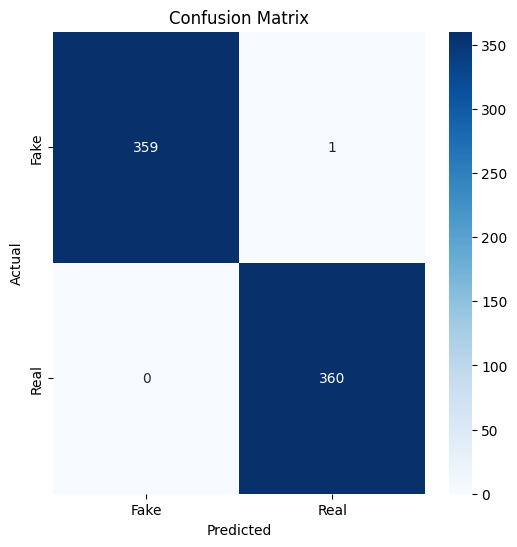

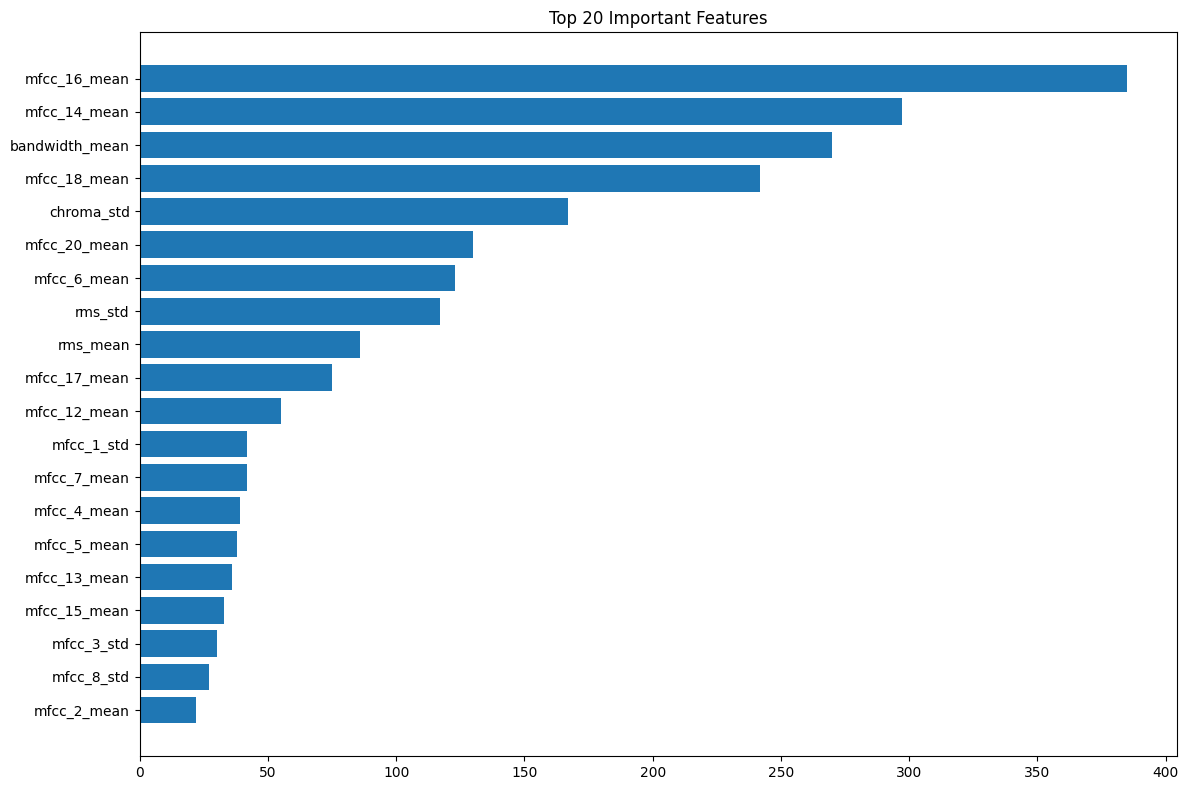


Saving model...
Model saved to audio_detection_model.pkl
Scaler saved to scaler.pkl

Prediction Results:
Fake probability: 1.0000
Real probability: 0.0000
Prediction: Fake

Top Contributing Features:
mfcc_16_mean: -6.6928
mfcc_18_mean: -2.1617
mfcc_14_mean: -1.9894
mfcc_20_mean: -0.9861
bandwidth_mean: -0.9546


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


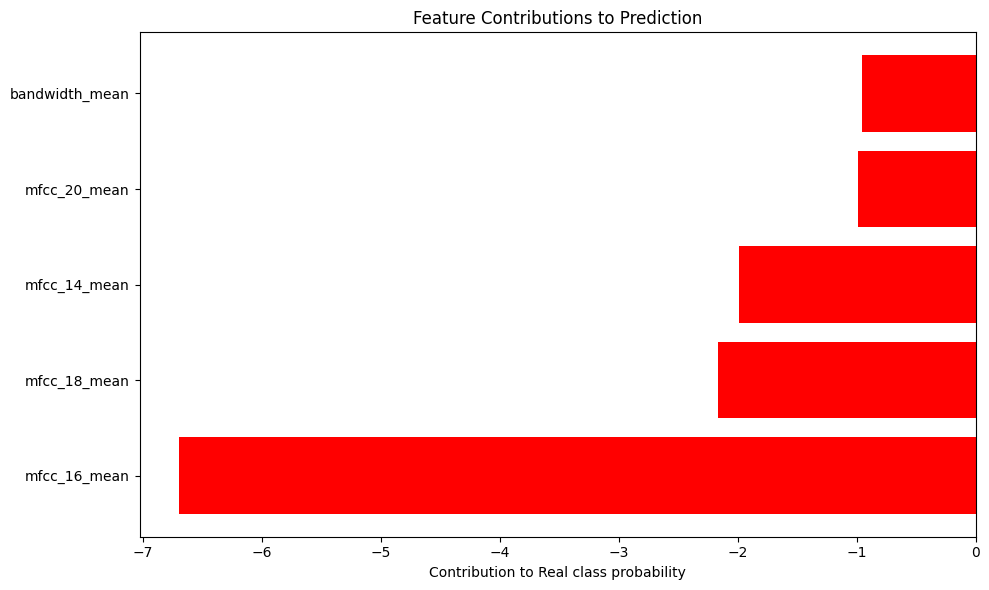

In [31]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# --------------------- SETTINGS ---------------------
DATA_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"
SR = 22050  # Sample rate
N_MFCC = 20  # Number of MFCC coefficients
TEST_SIZE = 0.2
RANDOM_STATE = 42
MODEL_SAVE_PATH = "audio_detection_model.pkl"
SCALER_SAVE_PATH = "scaler.pkl"

# --------------------- FEATURE EXTRACTION ---------------------
def extract_features(file_path):
    """Extract audio features from file"""
    try:
        audio, _ = librosa.load(file_path, sr=SR)

        features = []

        # MFCCs
        mfcc = librosa.feature.mfcc(y=audio, sr=SR, n_mfcc=N_MFCC)
        features.extend(np.mean(mfcc, axis=1))
        features.extend(np.std(mfcc, axis=1))

        # Chroma Features
        chroma = librosa.feature.chroma_stft(y=audio, sr=SR)
        features.append(np.mean(chroma))
        features.append(np.std(chroma))

        # Spectral Features
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=SR)
        features.append(np.mean(spectral_centroid))
        features.append(np.std(spectral_centroid))

        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=SR)
        features.append(np.mean(spectral_bandwidth))
        features.append(np.std(spectral_bandwidth))

        # Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(audio)
        features.append(np.mean(zcr))
        features.append(np.std(zcr))

        # RMS Energy
        rms = librosa.feature.rms(y=audio)
        features.append(np.mean(rms))
        features.append(np.std(rms))

        # Spectral Rolloff
        rolloff = librosa.feature.spectral_rolloff(y=audio, sr=SR)
        features.append(np.mean(rolloff))
        features.append(np.std(rolloff))

        return np.array(features)

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

# --------------------- DATA LOADING ---------------------
def load_dataset(data_dir):
    """Load and label all audio files"""
    X = []
    y = []

    # Process real audio files
    real_dir = os.path.join(data_dir, "real")
    for filename in os.listdir(real_dir):
        if filename.endswith(".wav"):
            filepath = os.path.join(real_dir, filename)
            features = extract_features(filepath)
            if features is not None:
                X.append(features)
                y.append(1)  # 1 for real audio

    # Process fake audio files
    fake_dir = os.path.join(data_dir, "fake")
    for filename in os.listdir(fake_dir):
        if filename.endswith(".wav"):
            filepath = os.path.join(fake_dir, filename)
            features = extract_features(filepath)
            if features is not None:
                X.append(features)
                y.append(0)  # 0 for fake audio

    return np.array(X), np.array(y)

# --------------------- MAIN TRAINING SCRIPT ---------------------
def train_model():
    # 1. Load and prepare data
    print("Loading dataset and extracting features...")
    X, y = load_dataset(DATA_DIR)

    # Create feature names
    feature_names = (
        [f"mfcc_{i}_mean" for i in range(1, N_MFCC+1)] +
        [f"mfcc_{i}_std" for i in range(1, N_MFCC+1)] +
        ["chroma_mean", "chroma_std",
         "centroid_mean", "centroid_std",
         "bandwidth_mean", "bandwidth_std",
         "zcr_mean", "zcr_std",
         "rms_mean", "rms_std",
         "rolloff_mean", "rolloff_std"]
    )

    # 2. Preprocess data
    print("Preprocessing data...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 3. Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=y
    )

    # 4. Train model
    print("Training model...")
    model = LGBMClassifier(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=7,
        num_leaves=31,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    model.fit(X_train, y_train)

    # 5. Evaluate model
    print("\nModel Evaluation:")
    y_pred = model.predict(X_test)

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Fake", "Real"],
                yticklabels=["Fake", "Real"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # 6. Feature Importance
    plt.figure(figsize=(12, 8))
    importance = model.feature_importances_
    sorted_idx = importance.argsort()
    plt.barh(np.array(feature_names)[sorted_idx[-20:]], importance[sorted_idx[-20:]])
    plt.title("Top 20 Important Features")
    plt.tight_layout()
    plt.show()

    # 7. Save model and scaler
    print("\nSaving model...")
    joblib.dump(model, MODEL_SAVE_PATH)
    joblib.dump(scaler, SCALER_SAVE_PATH)
    print(f"Model saved to {MODEL_SAVE_PATH}")
    print(f"Scaler saved to {SCALER_SAVE_PATH}")

    return model, scaler, feature_names

# --------------------- PREDICTION FUNCTION ---------------------
def predict_audio(file_path, model, scaler, feature_names):
    """Predict whether an audio file is real or fake"""
    features = extract_features(file_path)
    if features is None:
        return "Error processing audio file"

    # Scale features
    features_scaled = scaler.transform([features])

    # Predict
    proba = model.predict_proba(features_scaled)[0]
    prediction = model.predict(features_scaled)[0]

    # Display results
    print("\nPrediction Results:")
    print(f"Fake probability: {proba[0]:.4f}")
    print(f"Real probability: {proba[1]:.4f}")
    print(f"Prediction: {'Fake' if prediction == 0 else 'Real'}")

    # Show top influencing features
    explain_prediction(features_scaled[0], model, feature_names)

    return prediction
def explain_prediction(features, model, feature_names, top_n=5):
    """Explain model prediction by showing top contributing features"""
    try:
        # Get feature contributions (shape will be [1, n_features + 1, n_classes] for multiclass)
        contributions = model.predict_proba([features], pred_contrib=True)

        # For binary classification, contributions shape is [1, n_features + 1]
        if len(contributions.shape) == 2:
            contributions = contributions[0][:-1]  # Remove the bias term
        else:
            # For multiclass, we take contributions to class 1 (real)
            contributions = contributions[0][:-1, 1]

        sorted_idx = np.argsort(np.abs(contributions))[::-1]

        print("\nTop Contributing Features:")
        for i in range(top_n):
            idx = sorted_idx[i]
            print(f"{feature_names[idx]}: {contributions[idx]:.4f}")

        plt.figure(figsize=(10, 6))
        colors = ['green' if x > 0 else 'red' for x in contributions[sorted_idx[:top_n]]]
        plt.barh(
            np.array(feature_names)[sorted_idx[:top_n]],
            contributions[sorted_idx[:top_n]],
            color=colors
        )
        plt.title("Feature Contributions to Prediction")
        plt.xlabel("Contribution to Real class probability")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not generate prediction explanation: {str(e)}")

# --------------------- MAIN EXECUTION ---------------------
if __name__ == "__main__":
    # Train and save model
    model, scaler, feature_names = train_model()

    # Example prediction
    test_file = "Data/Fake/fake_1.wav"  # Replace with your file
    if os.path.exists(test_file):
        predict_audio(test_file, model, scaler, feature_names)
    else:
        print(f"\nTest file {test_file} not found. Skipping prediction demo.")

Loading dataset and extracting features...
Preprocessing data...
Training model...
[LightGBM] [Info] Number of positive: 1440, number of negative: 1440
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


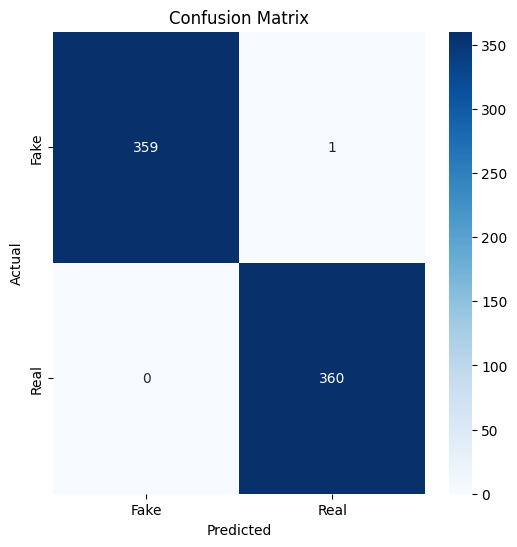

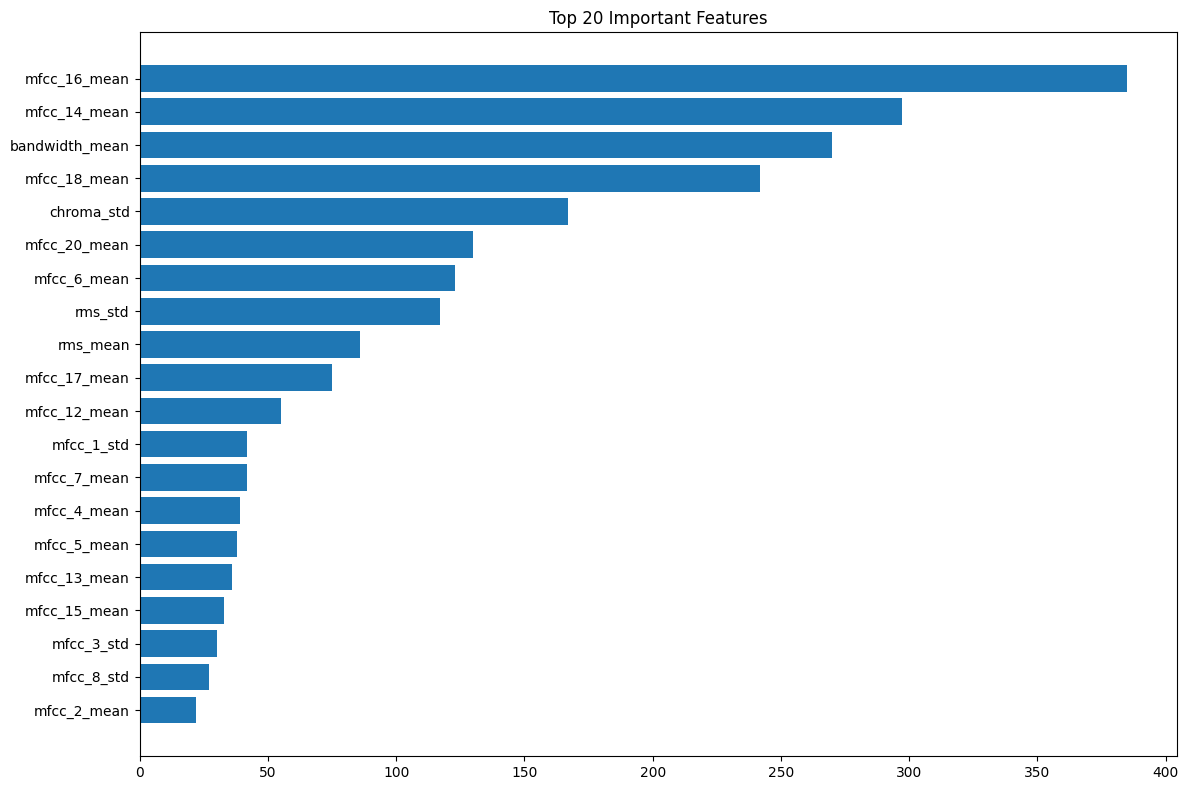


Generating SHAP summary plot...


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
C:\Users\adity\AppData\Local\Temp\ipykernel_24080\4110342250.py:182: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[1], X_train, feature_names=feature_names, show=False)


AssertionError: Summary plots need a matrix of shap_values, not a vector.

<Figure size 640x480 with 0 Axes>

In [32]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
from lime import lime_tabular

# --------------------- SETTINGS ---------------------
DATA_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"
SR = 22050  # Sample rate
N_MFCC = 20  # Number of MFCC coefficients
TEST_SIZE = 0.2
RANDOM_STATE = 42
MODEL_SAVE_PATH = "audio_detection_model_1.pkl"
SCALER_SAVE_PATH = "scaler_1.pkl"
SAMPLE_SAVE_PATH = "X_train_sample.pkl"  # Sample data for LIME explainer

# --------------------- FEATURE EXTRACTION ---------------------
def extract_features(file_path):
    """Extract audio features from file"""
    try:
        audio, _ = librosa.load(file_path, sr=SR)

        features = []

        # MFCCs
        mfcc = librosa.feature.mfcc(y=audio, sr=SR, n_mfcc=N_MFCC)
        features.extend(np.mean(mfcc, axis=1))
        features.extend(np.std(mfcc, axis=1))

        # Chroma Features
        chroma = librosa.feature.chroma_stft(y=audio, sr=SR)
        features.append(np.mean(chroma))
        features.append(np.std(chroma))

        # Spectral Features
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=SR)
        features.append(np.mean(spectral_centroid))
        features.append(np.std(spectral_centroid))

        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=SR)
        features.append(np.mean(spectral_bandwidth))
        features.append(np.std(spectral_bandwidth))

        # Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(audio)
        features.append(np.mean(zcr))
        features.append(np.std(zcr))

        # RMS Energy
        rms = librosa.feature.rms(y=audio)
        features.append(np.mean(rms))
        features.append(np.std(rms))

        # Spectral Rolloff
        rolloff = librosa.feature.spectral_rolloff(y=audio, sr=SR)
        features.append(np.mean(rolloff))
        features.append(np.std(rolloff))

        return np.array(features)

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

# --------------------- DATA LOADING ---------------------
def load_dataset(data_dir):
    """Load and label all audio files"""
    X = []
    y = []

    # Process real audio files
    real_dir = os.path.join(data_dir, "real")
    for filename in os.listdir(real_dir):
        if filename.endswith(".wav"):
            filepath = os.path.join(real_dir, filename)
            features = extract_features(filepath)
            if features is not None:
                X.append(features)
                y.append(1)  # 1 for real audio

    # Process fake audio files
    fake_dir = os.path.join(data_dir, "fake")
    for filename in os.listdir(fake_dir):
        if filename.endswith(".wav"):
            filepath = os.path.join(fake_dir, filename)
            features = extract_features(filepath)
            if features is not None:
                X.append(features)
                y.append(0)  # 0 for fake audio

    return np.array(X), np.array(y)

# --------------------- MAIN TRAINING SCRIPT ---------------------
def train_model():
    # 1. Load and prepare data
    print("Loading dataset and extracting features...")
    X, y = load_dataset(DATA_DIR)

    # Create feature names
    feature_names = (
        [f"mfcc_{i}_mean" for i in range(1, N_MFCC+1)] +
        [f"mfcc_{i}_std" for i in range(1, N_MFCC+1)] +
        ["chroma_mean", "chroma_std",
         "centroid_mean", "centroid_std",
         "bandwidth_mean", "bandwidth_std",
         "zcr_mean", "zcr_std",
         "rms_mean", "rms_std",
         "rolloff_mean", "rolloff_std"]
    )

    # 2. Preprocess data
    print("Preprocessing data...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 3. Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=y
    )

    # Save a sample of the training data for LIME explainer
    sample_indices = np.random.choice(X_train.shape[0], size=min(1000, X_train.shape[0]), replace=False)
    X_train_sample = X_train[sample_indices]
    joblib.dump(X_train_sample, SAMPLE_SAVE_PATH)

    # 4. Train model
    print("Training model...")
    model = LGBMClassifier(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=7,
        num_leaves=31,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    model.fit(X_train, y_train)

    # 5. Evaluate model
    print("\nModel Evaluation:")
    y_pred = model.predict(X_test)

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Fake", "Real"],
                yticklabels=["Fake", "Real"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # 6. Feature Importance
    plt.figure(figsize=(12, 8))
    importance = model.feature_importances_
    sorted_idx = importance.argsort()
    plt.barh(np.array(feature_names)[sorted_idx[-20:]], importance[sorted_idx[-20:]])
    plt.title("Top 20 Important Features")
    plt.tight_layout()
    plt.show()

    # 7. SHAP Global Explanation
    print("\nGenerating SHAP summary plot...")
    explainer_shap = shap.TreeExplainer(model)
    shap_values = explainer_shap.shap_values(X_train)
    shap.summary_plot(shap_values[1], X_train, feature_names=feature_names, show=False)
    plt.title("SHAP Summary Plot for Real Class")
    plt.tight_layout()
    plt.show()

    # 8. Save model, scaler, and sample data
    print("\nSaving model...")
    joblib.dump(model, MODEL_SAVE_PATH)
    joblib.dump(scaler, SCALER_SAVE_PATH)
    print(f"Model saved to {MODEL_SAVE_PATH}")
    print(f"Scaler saved to {SCALER_SAVE_PATH}")
    print(f"Sample data saved to {SAMPLE_SAVE_PATH}")

    return model, scaler, feature_names

# --------------------- PREDICTION FUNCTION ---------------------
def predict_audio(file_path, model, scaler, feature_names):
    """Predict whether an audio file is real or fake"""
    features = extract_features(file_path)
    if features is None:
        return "Error processing audio file"

    # Scale features
    features_scaled = scaler.transform([features])

    # Predict
    proba = model.predict_proba(features_scaled)[0]
    prediction = model.predict(features_scaled)[0]

    # Display results
    print("\nPrediction Results:")
    print(f"Fake probability: {proba[0]:.4f}")
    print(f"Real probability: {proba[1]:.4f}")
    print(f"Prediction: {'Fake' if prediction == 0 else 'Real'}")

    # Show top influencing features using LightGBM's contributions
    explain_prediction(features_scaled[0], model, feature_names)

    # SHAP force plot explanation
    try:
        print("\nGenerating SHAP explanation...")
        explainer_shap = shap.TreeExplainer(model)
        shap_values_single = explainer_shap.shap_values(features_scaled)
        shap_expected_value = explainer_shap.expected_value[1]
        shap_values_positive = shap_values_single[1]

        plt.figure()
        shap.force_plot(
            shap_expected_value,
            shap_values_positive[0],
            features_scaled[0],
            feature_names=feature_names,
            matplotlib=True,
            show=False
        )
        plt.title("SHAP Force Plot")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error generating SHAP explanation: {e}")

    # LIME explanation
    try:
        print("\nGenerating LIME explanation...")
        X_train_sample = joblib.load(SAMPLE_SAVE_PATH)
        explainer_lime = lime_tabular.LimeTabularExplainer(
            training_data=X_train_sample,
            feature_names=feature_names,
            class_names=['Fake', 'Real'],
            mode='classification',
            discretize_continuous=False
        )

        exp = explainer_lime.explain_instance(
            data_row=features_scaled[0],
            predict_fn=model.predict_proba,
            num_features=5,
            top_labels=1
        )

        print("\nLIME Explanation:")
        print(f"Predicted class: {'Real' if prediction == 1 else 'Fake'}")
        label = exp.top_labels[0]
        print(f"Explanation for {'Real' if label == 1 else 'Fake'} class:")
        for feature, weight in exp.local_exp[label]:
            print(f"{feature_names[feature]}: {weight:.4f}")

        fig = exp.as_pyplot_figure()
        plt.title("LIME Explanation")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error generating LIME explanation: {e}")

    return prediction

def explain_prediction(features, model, feature_names, top_n=5):
    """Explain model prediction by showing top contributing features"""
    try:
        contributions = model.predict_proba([features], pred_contrib=True)[0][:-1]
        sorted_idx = np.argsort(np.abs(contributions))[::-1]

        print("\nTop Contributing Features (LightGBM):")
        for i in range(top_n):
            idx = sorted_idx[i]
            print(f"{feature_names[idx]}: {contributions[idx]:.4f}")

        plt.figure(figsize=(10, 6))
        colors = ['green' if x > 0 else 'red' for x in contributions[sorted_idx[:top_n]]]
        plt.barh(
            np.array(feature_names)[sorted_idx[:top_n]],
            contributions[sorted_idx[:top_n]],
            color=colors
        )
        plt.title("Feature Contributions (LightGBM)")
        plt.xlabel("Contribution to Real class probability")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not generate prediction explanation: {str(e)}")

# --------------------- MAIN EXECUTION ---------------------
if __name__ == "__main__":
    # Train and save model
    model, scaler, feature_names = train_model()

    # Example prediction
    test_file = "Data/Fake/fake_1.wav"  # Replace with your file
    if os.path.exists(test_file):
        predict_audio(test_file, model, scaler, feature_names)
    else:
        print(f"\nTest file {test_file} not found. Skipping prediction demo.")

Loading dataset and extracting features...
Preprocessing data...
Training model...
[LightGBM] [Info] Number of positive: 1440, number of negative: 1440
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


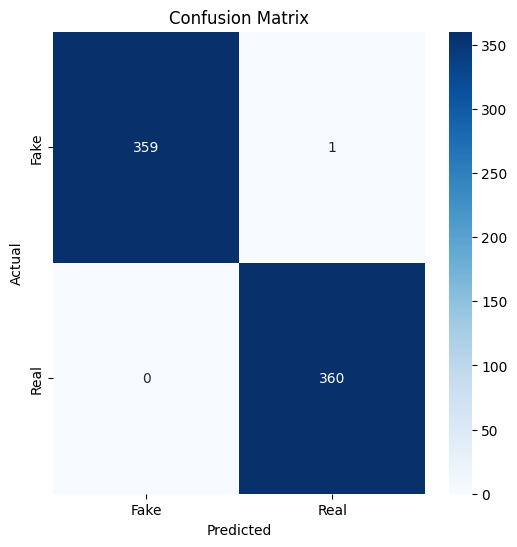

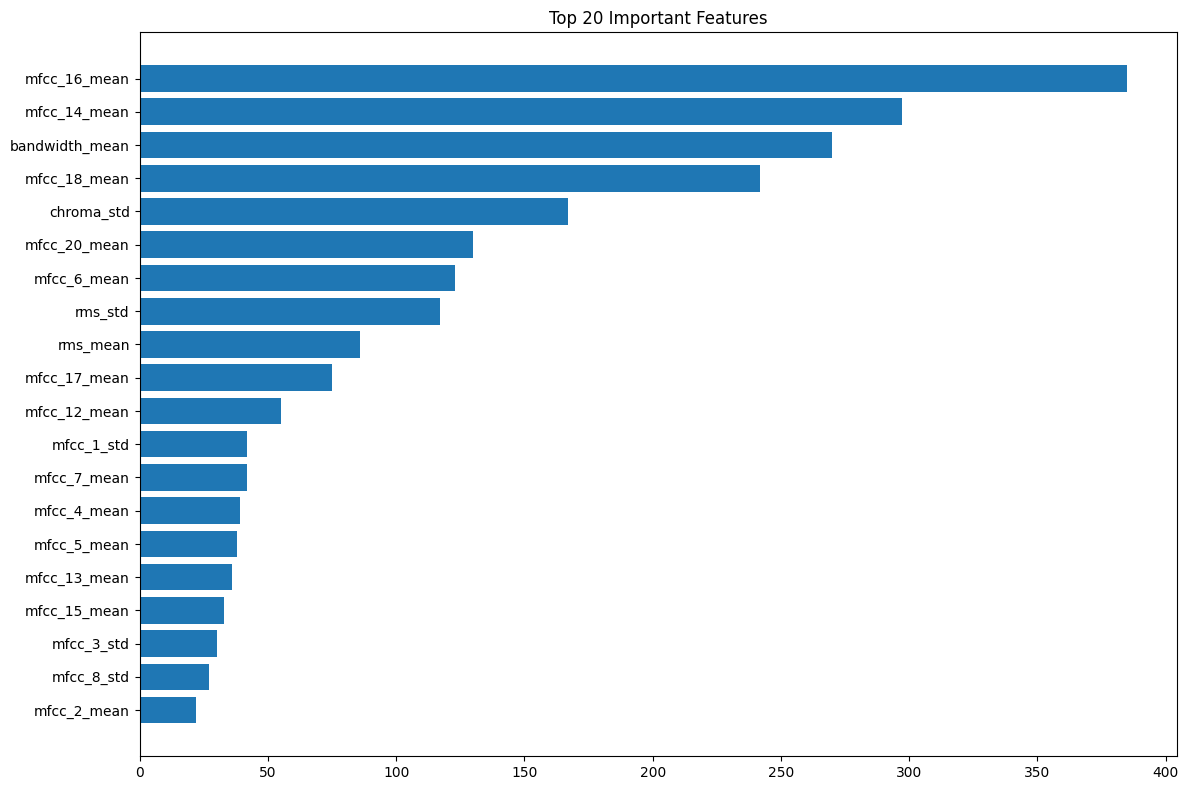


Saving model...
Model saved to audio_detection_model.pkl
Scaler saved to scaler.pkl

Prediction Results:
Fake probability: 1.0000
Real probability: 0.0000
Prediction: Fake


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [30]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# --------------------- SETTINGS ---------------------
DATA_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"
SR = 22050  # Sample rate
N_MFCC = 20  # Number of MFCC coefficients
TEST_SIZE = 0.2
RANDOM_STATE = 42
MODEL_SAVE_PATH = "audio_detection_model.pkl"
SCALER_SAVE_PATH = "scaler.pkl"

# --------------------- FEATURE EXTRACTION ---------------------
def extract_features(file_path):
    """Extract audio features from file"""
    try:
        audio, _ = librosa.load(file_path, sr=SR)

        features = []

        # MFCCs
        mfcc = librosa.feature.mfcc(y=audio, sr=SR, n_mfcc=N_MFCC)
        features.extend(np.mean(mfcc, axis=1))
        features.extend(np.std(mfcc, axis=1))

        # Chroma Features
        chroma = librosa.feature.chroma_stft(y=audio, sr=SR)
        features.append(np.mean(chroma))
        features.append(np.std(chroma))

        # Spectral Features
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=SR)
        features.append(np.mean(spectral_centroid))
        features.append(np.std(spectral_centroid))

        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=SR)
        features.append(np.mean(spectral_bandwidth))
        features.append(np.std(spectral_bandwidth))

        # Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(audio)
        features.append(np.mean(zcr))
        features.append(np.std(zcr))

        # RMS Energy
        rms = librosa.feature.rms(y=audio)
        features.append(np.mean(rms))
        features.append(np.std(rms))

        # Spectral Rolloff
        rolloff = librosa.feature.spectral_rolloff(y=audio, sr=SR)
        features.append(np.mean(rolloff))
        features.append(np.std(rolloff))

        return np.array(features)

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

# --------------------- DATA LOADING ---------------------
def load_dataset(data_dir):
    """Load and label all audio files"""
    X = []
    y = []

    # Process real audio files
    real_dir = os.path.join(data_dir, "real")
    for filename in os.listdir(real_dir):
        if filename.endswith(".wav"):
            filepath = os.path.join(real_dir, filename)
            features = extract_features(filepath)
            if features is not None:
                X.append(features)
                y.append(1)  # 1 for real audio

    # Process fake audio files
    fake_dir = os.path.join(data_dir, "fake")
    for filename in os.listdir(fake_dir):
        if filename.endswith(".wav"):
            filepath = os.path.join(fake_dir, filename)
            features = extract_features(filepath)
            if features is not None:
                X.append(features)
                y.append(0)  # 0 for fake audio

    return np.array(X), np.array(y)

# --------------------- MAIN TRAINING SCRIPT ---------------------
def train_model():
    # 1. Load and prepare data
    print("Loading dataset and extracting features...")
    X, y = load_dataset(DATA_DIR)

    # Create feature names
    feature_names = (
        [f"mfcc_{i}_mean" for i in range(1, N_MFCC+1)] +
        [f"mfcc_{i}_std" for i in range(1, N_MFCC+1)] +
        ["chroma_mean", "chroma_std",
         "centroid_mean", "centroid_std",
         "bandwidth_mean", "bandwidth_std",
         "zcr_mean", "zcr_std",
         "rms_mean", "rms_std",
         "rolloff_mean", "rolloff_std"]
    )

    # 2. Preprocess data
    print("Preprocessing data...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 3. Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=y
    )

    # 4. Train model
    print("Training model...")
    model = LGBMClassifier(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=7,
        num_leaves=31,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    model.fit(X_train, y_train)

    # 5. Evaluate model
    print("\nModel Evaluation:")
    y_pred = model.predict(X_test)

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Fake", "Real"],
                yticklabels=["Fake", "Real"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # 6. Feature Importance
    plt.figure(figsize=(12, 8))
    importance = model.feature_importances_
    sorted_idx = importance.argsort()
    plt.barh(np.array(feature_names)[sorted_idx[-20:]], importance[sorted_idx[-20:]])
    plt.title("Top 20 Important Features")
    plt.tight_layout()
    plt.show()

    # 7. Save model and scaler
    print("\nSaving model...")
    joblib.dump(model, MODEL_SAVE_PATH)
    joblib.dump(scaler, SCALER_SAVE_PATH)
    print(f"Model saved to {MODEL_SAVE_PATH}")
    print(f"Scaler saved to {SCALER_SAVE_PATH}")

    return model, scaler, feature_names

# --------------------- PREDICTION FUNCTION ---------------------
def predict_audio(file_path, model, scaler, feature_names):
    """Predict whether an audio file is real or fake"""
    features = extract_features(file_path)
    if features is None:
        return "Error processing audio file"

    # Scale features
    features_scaled = scaler.transform([features])

    # Predict
    proba = model.predict_proba(features_scaled)[0]
    prediction = model.predict(features_scaled)[0]

    # Display results
    print("\nPrediction Results:")
    print(f"Fake probability: {proba[0]:.4f}")
    print(f"Real probability: {proba[1]:.4f}")
    print(f"Prediction: {'Fake' if prediction == 0 else 'Real'}")

    # Show top influencing features
    explain_prediction(features_scaled[0], model, feature_names)

    return prediction

def explain_prediction(features, model, feature_names, top_n=5):
    """Explain model prediction by showing top contributing features"""
    contributions = model.predict_proba([features], pred_contrib=True)[0][:-1, 1]

    sorted_idx = np.argsort(np.abs(contributions))[::-1]

    print("\nTop Contributing Features:")
    for i in range(top_n):
        idx = sorted_idx[i]
        print(f"{feature_names[idx]}: {contributions[idx]:.4f}")

    plt.figure(figsize=(10, 6))
    colors = ['green' if x > 0 else 'red' for x in contributions[sorted_idx[:top_n]]]
    plt.barh(
        np.array(feature_names)[sorted_idx[:top_n]],
        contributions[sorted_idx[:top_n]],
        color=colors
    )
    plt.title("Feature Contributions to Prediction")
    plt.xlabel("Contribution to Real class probability")
    plt.tight_layout()
    plt.show()

# --------------------- MAIN EXECUTION ---------------------
if __name__ == "__main__":
    # Train and save model
    model, scaler, feature_names = train_model()

    # Example prediction
    test_file = "Data/Fake/fake_1.wav"  # Replace with your file
    if os.path.exists(test_file):
        predict_audio(test_file, model, scaler, feature_names)
    else:
        print(f"\nTest file {test_file} not found. Skipping prediction demo.")

Loading dataset and extracting features...
Preprocessing data...
Training model...
[LightGBM] [Info] Number of positive: 1440, number of negative: 1440
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.9986

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       360
           1       1.00      1.00      1.00       360

    accuracy                           1.00       720
   macro avg       1.00      1.00      1.00       720
weighted avg       1.00      1.00      1.00       720



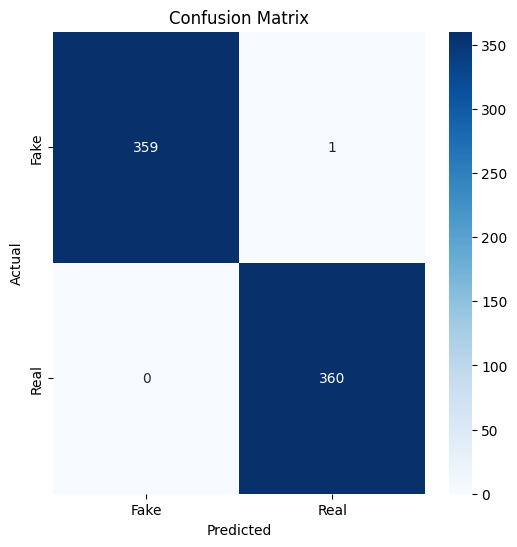

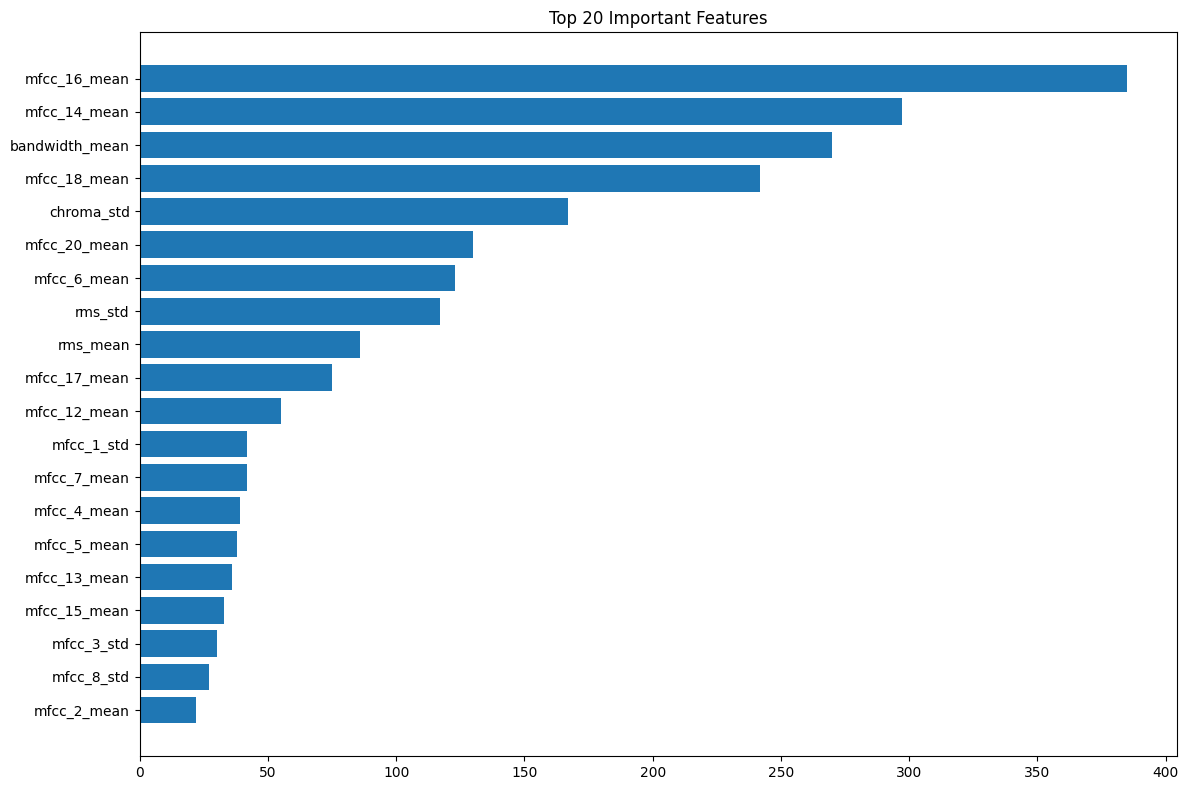


Generating SHAP summary plot...


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
C:\Users\adity\AppData\Local\Temp\ipykernel_24080\2546760190.py:192: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_matrix, X_train, feature_names=feature_names, show=False)


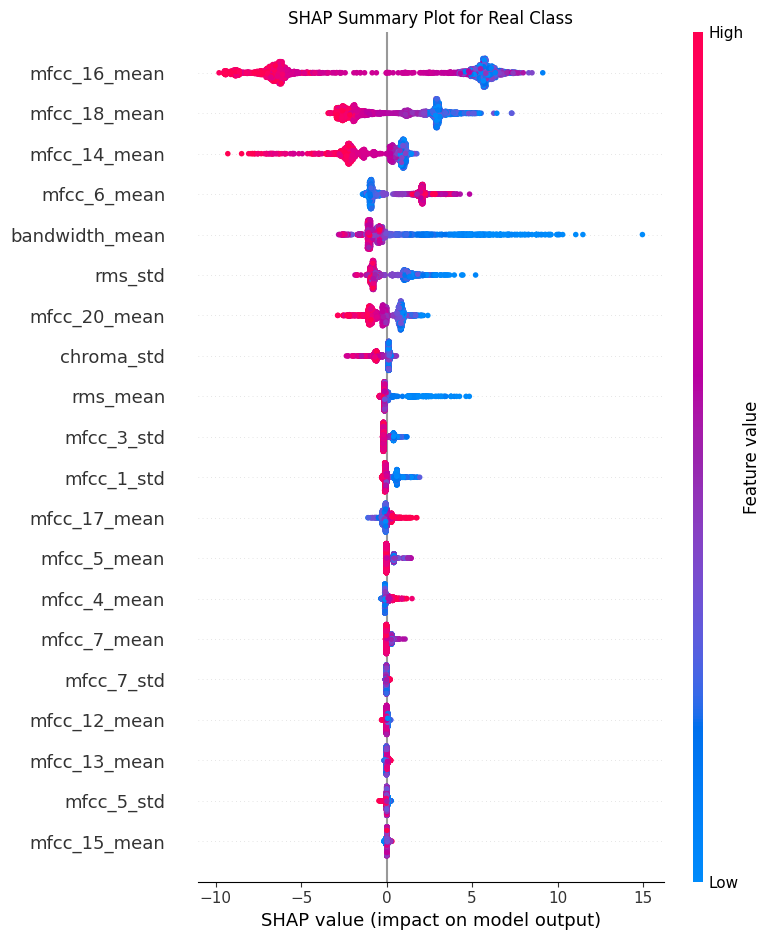


Saving model...
Model saved to audio_detection_model_1.pkl
Scaler saved to scaler_1.pkl
Sample data saved to X_train_sample.pkl

Prediction Results:
Fake probability: 1.0000
Real probability: 0.0000
Prediction: Fake

Top Contributing Features (LightGBM):
mfcc_16_mean: -6.6928
mfcc_18_mean: -2.1617
mfcc_14_mean: -1.9894
mfcc_20_mean: -0.9861
bandwidth_mean: -0.9546


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


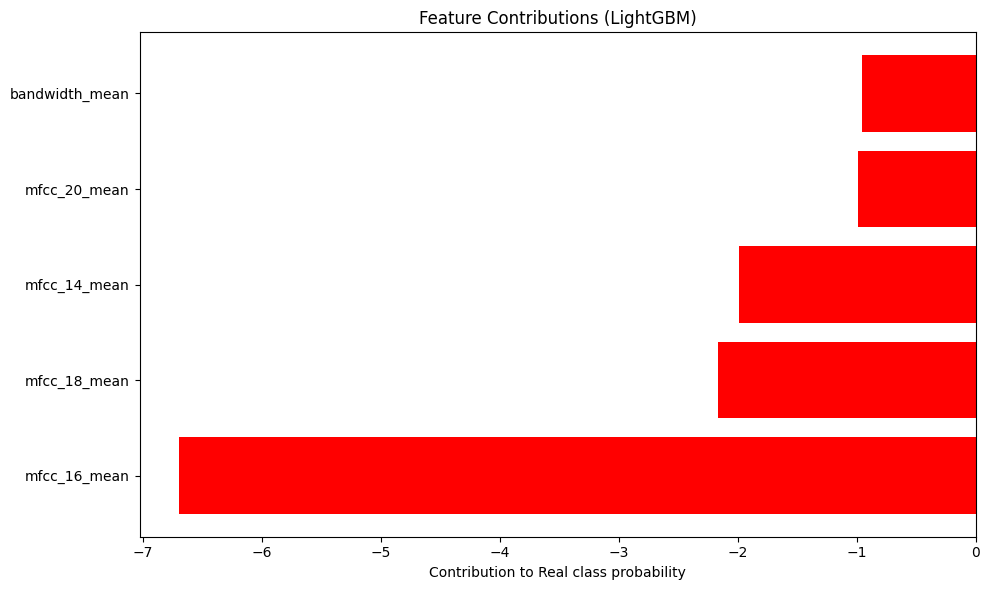


Generating SHAP explanation...


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


<Figure size 640x480 with 0 Axes>

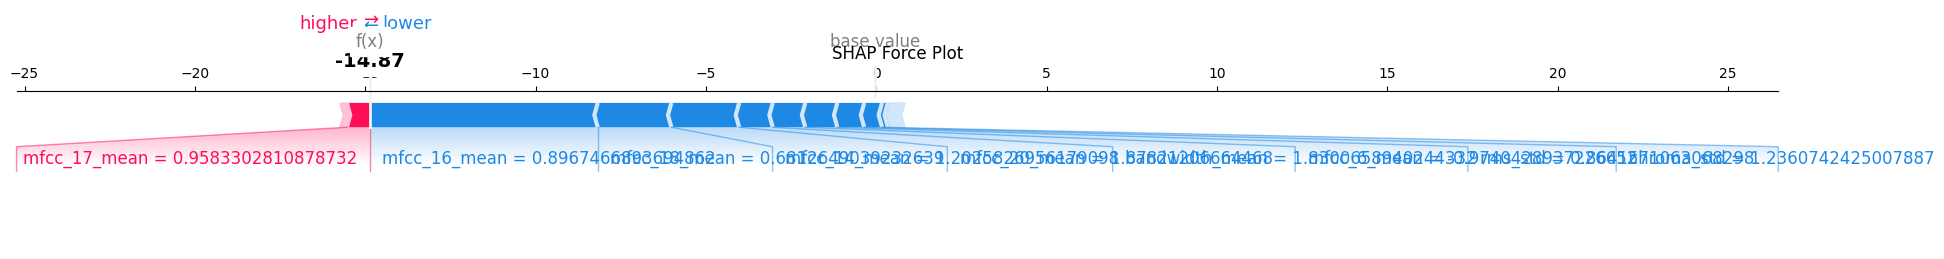


Generating LIME explanation...


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



LIME Explanation:
Predicted class: Fake
Explanation for Fake class:
mfcc_16_mean: 0.1765
mfcc_18_mean: 0.1348
mfcc_14_mean: 0.1212
bandwidth_mean: 0.0823
mfcc_6_mean: -0.0761
Error generating LIME explanation: 1


In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
from lime import lime_tabular

# --------------------- SETTINGS ---------------------
DATA_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"
SR = 22050  # Sample rate
N_MFCC = 20  # Number of MFCC coefficients
TEST_SIZE = 0.2
RANDOM_STATE = 42
MODEL_SAVE_PATH = "audio_detection_model_1.pkl"
SCALER_SAVE_PATH = "scaler_1.pkl"
SAMPLE_SAVE_PATH = "X_train_sample.pkl"  # Sample data for LIME explainer

# --------------------- FEATURE EXTRACTION ---------------------
def extract_features(file_path):
    """Extract audio features from file"""
    try:
        audio, _ = librosa.load(file_path, sr=SR)

        features = []

        # MFCCs
        mfcc = librosa.feature.mfcc(y=audio, sr=SR, n_mfcc=N_MFCC)
        features.extend(np.mean(mfcc, axis=1))
        features.extend(np.std(mfcc, axis=1))

        # Chroma Features
        chroma = librosa.feature.chroma_stft(y=audio, sr=SR)
        features.append(np.mean(chroma))
        features.append(np.std(chroma))

        # Spectral Features
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=SR)
        features.append(np.mean(spectral_centroid))
        features.append(np.std(spectral_centroid))

        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=SR)
        features.append(np.mean(spectral_bandwidth))
        features.append(np.std(spectral_bandwidth))

        # Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(audio)
        features.append(np.mean(zcr))
        features.append(np.std(zcr))

        # RMS Energy
        rms = librosa.feature.rms(y=audio)
        features.append(np.mean(rms))
        features.append(np.std(rms))

        # Spectral Rolloff
        rolloff = librosa.feature.spectral_rolloff(y=audio, sr=SR)
        features.append(np.mean(rolloff))
        features.append(np.std(rolloff))

        return np.array(features)

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

# --------------------- DATA LOADING ---------------------
def load_dataset(data_dir):
    """Load and label all audio files"""
    X = []
    y = []

    # Process real audio files
    real_dir = os.path.join(data_dir, "real")
    for filename in os.listdir(real_dir):
        if filename.endswith(".wav"):
            filepath = os.path.join(real_dir, filename)
            features = extract_features(filepath)
            if features is not None:
                X.append(features)
                y.append(1)  # 1 for real audio

    # Process fake audio files
    fake_dir = os.path.join(data_dir, "fake")
    for filename in os.listdir(fake_dir):
        if filename.endswith(".wav"):
            filepath = os.path.join(fake_dir, filename)
            features = extract_features(filepath)
            if features is not None:
                X.append(features)
                y.append(0)  # 0 for fake audio

    return np.array(X), np.array(y)

# --------------------- MAIN TRAINING SCRIPT ---------------------
def train_model():
    # 1. Load and prepare data
    print("Loading dataset and extracting features...")
    X, y = load_dataset(DATA_DIR)

    # Create feature names
    feature_names = (
        [f"mfcc_{i}_mean" for i in range(1, N_MFCC+1)] +
        [f"mfcc_{i}_std" for i in range(1, N_MFCC+1)] +
        ["chroma_mean", "chroma_std",
         "centroid_mean", "centroid_std",
         "bandwidth_mean", "bandwidth_std",
         "zcr_mean", "zcr_std",
         "rms_mean", "rms_std",
         "rolloff_mean", "rolloff_std"]
    )

    # 2. Preprocess data
    print("Preprocessing data...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 3. Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=y
    )

    # Save a sample of the training data for LIME explainer
    sample_indices = np.random.choice(X_train.shape[0], size=min(1000, X_train.shape[0]), replace=False)
    X_train_sample = X_train[sample_indices]
    joblib.dump(X_train_sample, SAMPLE_SAVE_PATH)

    # 4. Train model
    print("Training model...")
    model = LGBMClassifier(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=7,
        num_leaves=31,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    model.fit(X_train, y_train)

    # 5. Evaluate model
    print("\nModel Evaluation:")
    y_pred = model.predict(X_test)

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Fake", "Real"],
                yticklabels=["Fake", "Real"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # 6. Feature Importance
    plt.figure(figsize=(12, 8))
    importance = model.feature_importances_
    sorted_idx = importance.argsort()
    plt.barh(np.array(feature_names)[sorted_idx[-20:]], importance[sorted_idx[-20:]])
    plt.title("Top 20 Important Features")
    plt.tight_layout()
    plt.show()

    # 7. SHAP Global Explanation
    print("\nGenerating SHAP summary plot...")
    try:
        explainer_shap = shap.TreeExplainer(model)
        shap_values = explainer_shap.shap_values(X_train)

        # For binary classification, LightGBM returns a list of arrays
        if isinstance(shap_values, list):
            # For binary classification, we'll use the SHAP values for class 1
            shap_values_matrix = shap_values[1]
        else:
            shap_values_matrix = shap_values

        plt.figure()
        shap.summary_plot(shap_values_matrix, X_train, feature_names=feature_names, show=False)
        plt.title("SHAP Summary Plot for Real Class")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error generating SHAP summary plot: {str(e)}")

    # 8. Save model, scaler, and sample data
    print("\nSaving model...")
    joblib.dump(model, MODEL_SAVE_PATH)
    joblib.dump(scaler, SCALER_SAVE_PATH)
    print(f"Model saved to {MODEL_SAVE_PATH}")
    print(f"Scaler saved to {SCALER_SAVE_PATH}")
    print(f"Sample data saved to {SAMPLE_SAVE_PATH}")

    return model, scaler, feature_names

# --------------------- PREDICTION FUNCTION ---------------------
def predict_audio(file_path, model, scaler, feature_names):
    """Predict whether an audio file is real or fake"""
    features = extract_features(file_path)
    if features is None:
        return "Error processing audio file"

    # Scale features
    features_scaled = scaler.transform([features])

    # Predict
    proba = model.predict_proba(features_scaled)[0]
    prediction = model.predict(features_scaled)[0]

    # Display results
    print("\nPrediction Results:")
    print(f"Fake probability: {proba[0]:.4f}")
    print(f"Real probability: {proba[1]:.4f}")
    print(f"Prediction: {'Fake' if prediction == 0 else 'Real'}")

    # Show top influencing features using LightGBM's contributions
    explain_prediction(features_scaled[0], model, feature_names)

    # SHAP force plot explanation
    try:
        print("\nGenerating SHAP explanation...")
        explainer_shap = shap.TreeExplainer(model)
        shap_values_single = explainer_shap.shap_values(features_scaled)

        # Handle binary classification case
        if isinstance(shap_values_single, list):
            shap_expected_value = explainer_shap.expected_value[1]
            shap_values_positive = shap_values_single[1]
        else:
            shap_expected_value = explainer_shap.expected_value
            shap_values_positive = shap_values_single

        plt.figure()
        shap.force_plot(
            shap_expected_value,
            shap_values_positive[0],
            features_scaled[0],
            feature_names=feature_names,
            matplotlib=True,
            show=False
        )
        plt.title("SHAP Force Plot")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error generating SHAP explanation: {e}")

    # LIME explanation
    try:
        print("\nGenerating LIME explanation...")
        X_train_sample = joblib.load(SAMPLE_SAVE_PATH)
        explainer_lime = lime_tabular.LimeTabularExplainer(
            training_data=X_train_sample,
            feature_names=feature_names,
            class_names=['Fake', 'Real'],
            mode='classification',
            discretize_continuous=False
        )

        exp = explainer_lime.explain_instance(
            data_row=features_scaled[0],
            predict_fn=model.predict_proba,
            num_features=5,
            top_labels=1
        )

        print("\nLIME Explanation:")
        print(f"Predicted class: {'Real' if prediction == 1 else 'Fake'}")
        label = exp.top_labels[0]
        print(f"Explanation for {'Real' if label == 1 else 'Fake'} class:")
        for feature, weight in exp.local_exp[label]:
            print(f"{feature_names[feature]}: {weight:.4f}")

        fig = exp.as_pyplot_figure()
        plt.title("LIME Explanation")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error generating LIME explanation: {e}")

    return prediction

def explain_prediction(features, model, feature_names, top_n=5):
    """Explain model prediction by showing top contributing features"""
    try:
        contributions = model.predict_proba([features], pred_contrib=True)[0][:-1]
        sorted_idx = np.argsort(np.abs(contributions))[::-1]

        print("\nTop Contributing Features (LightGBM):")
        for i in range(top_n):
            idx = sorted_idx[i]
            print(f"{feature_names[idx]}: {contributions[idx]:.4f}")

        plt.figure(figsize=(10, 6))
        colors = ['green' if x > 0 else 'red' for x in contributions[sorted_idx[:top_n]]]
        plt.barh(
            np.array(feature_names)[sorted_idx[:top_n]],
            contributions[sorted_idx[:top_n]],
            color=colors
        )
        plt.title("Feature Contributions (LightGBM)")
        plt.xlabel("Contribution to Real class probability")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not generate prediction explanation: {str(e)}")

# --------------------- MAIN EXECUTION ---------------------
if __name__ == "__main__":
    # Train and save model
    model, scaler, feature_names = train_model()

    # Example prediction
    test_file = os.path.join(DATA_DIR, "Fake/fake_1.wav")  # Replace with your file
    if os.path.exists(test_file):
        predict_audio(test_file, model, scaler, feature_names)
    else:
        print(f"\nTest file {test_file} not found. Skipping prediction demo.")

In [34]:
import os

file_path = "X_train_sample.pkl"
file_size_bytes = os.path.getsize(file_path)
file_size_kb = file_size_bytes / 1024
file_size_mb = file_size_kb / 1024

print(f"Size of {file_path}: {file_size_bytes:.2f} bytes ({file_size_kb:.2f} KB / {file_size_mb:.2f} MB)")


Size of X_train_sample.pkl: 416241.00 bytes (406.49 KB / 0.40 MB)


In [35]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import lime
import lime.lime_tabular
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# ==== Paths ====
DATASET_PATH = "features_extracted.csv"
SAMPLE_SAVE_PATH = "X_train_sample.pkl"
SHAP_SUMMARY_PATH = "shap_summary_plot.png"

# ==== Load Data ====
df = pd.read_csv(DATASET_PATH)
X = df.drop("label", axis=1)
y = df["label"]

# ==== Train/Test Split ====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==== Scale Features ====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==== Train LightGBM ====
model = lgb.LGBMClassifier()
model.fit(X_train_scaled, y_train)

# ==== Evaluate ====
print("\nClassification Report:\n")
print(classification_report(y_test, model.predict(X_test_scaled)))

# ==== Save Sample for LIME ====
sample_size = 1000
X_train_sample = pd.DataFrame(X_train_scaled, columns=X.columns).sample(n=sample_size, random_state=42)

with open(SAMPLE_SAVE_PATH, "wb") as f:
    pickle.dump(X_train_sample, f)

print(f"\nSample saved to: {SAMPLE_SAVE_PATH}")
print(f"Size of X_train_sample.pkl: {os.path.getsize(SAMPLE_SAVE_PATH):,.2f} bytes")

# ==== SHAP Explanation ====
explainer = shap.Explainer(model)
shap_values = explainer(X_train_scaled[:100])  # Only use a slice for speed

plt.figure()
shap.summary_plot(shap_values, features=X_train.iloc[:100], feature_names=X.columns, show=False)
plt.tight_layout()
plt.savefig(SHAP_SUMMARY_PATH)
plt.close()
print(f"\nSHAP summary plot saved as: {SHAP_SUMMARY_PATH}")

# ==== LIME Explanation ====
# Load sample
with open(SAMPLE_SAVE_PATH, "rb") as f:
    X_train_sample = pickle.load(f)

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_sample),
    feature_names=X.columns.tolist(),
    class_names=["Real", "Fake"],
    mode="classification"
)

# Choose a test instance to explain
idx = 0
instance = X_test_scaled[idx].reshape(1, -1)
exp = lime_explainer.explain_instance(
    data_row=X_test_scaled[idx],
    predict_fn=model.predict_proba
)

# Save LIME Explanation
exp.save_to_file("lime_explanation.html")
print("\nLIME explanation saved as: lime_explanation.html")


FileNotFoundError: [Errno 2] No such file or directory: 'features_extracted.csv'

In [37]:
import streamlit as st

# Page config must be first Streamlit command
st.set_page_config(
    page_title="Audio Authenticity Analyzer",
    page_icon="🔊",
    layout="wide",
    initial_sidebar_state="expanded"
)

import os
import librosa
import numpy as np
import joblib
import matplotlib.pyplot as plt
import shap
from lime import lime_tabular

# Constants
N_MFCC = 20
MODEL_PATH = "audio_detection_model_1.pkl"
SCALER_PATH = "scaler_1.pkl"
SAMPLE_PATH = "X_train_sample.pkl"

# Feature names (must match training code)
feature_names = (
    [f"mfcc_{i}_mean" for i in range(1, N_MFCC+1)] +
    [f"mfcc_{i}_std" for i in range(1, N_MFCC+1)] +
    ["chroma_mean", "chroma_std",
     "centroid_mean", "centroid_std",
     "bandwidth_mean", "bandwidth_std",
     "zcr_mean", "zcr_std",
     "rms_mean", "rms_std",
     "rolloff_mean", "rolloff_std"]
)

@st.cache_resource
def load_resources():
    try:
        model = joblib.load(MODEL_PATH)
        scaler = joblib.load(SCALER_PATH)
        X_train_sample = joblib.load(SAMPLE_PATH)

        if not hasattr(model, 'predict_proba'):
            raise ValueError("Model doesn't support probability predictions")
        if not hasattr(scaler, 'transform'):
            raise ValueError("Invalid scaler object")
        if X_train_sample.shape[1] != len(feature_names):
            raise ValueError(f"Feature dimension mismatch. Expected {len(feature_names)}, got {X_train_sample.shape[1]}")

        return model, scaler, X_train_sample
    except Exception as e:
        st.error(f"Initialization Error: {str(e)}")
        st.write("**Troubleshooting:**")
        st.write("1. Verify all model files exist in the correct location")
        st.write("2. Check file versions match training code")
        st.write("3. Ensure consistent feature extraction parameters")
        st.stop()

model, scaler, X_train_sample = load_resources()

def extract_features(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=22050)

        if sr != 22050:
            st.warning(f"Unexpected sample rate {sr}, resampling to 22050")
            audio = librosa.resample(audio, orig_sr=sr, target_sr=22050)
        if len(audio) < 1024:
            raise ValueError("Audio too short (min 1024 samples required)")

        features = []

        mfcc = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=N_MFCC)
        features.extend(np.mean(mfcc, axis=1))
        features.extend(np.std(mfcc, axis=1))

        chroma = librosa.feature.chroma_stft(y=audio, sr=22050)
        features.append(np.mean(chroma))
        features.append(np.std(chroma))

        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=22050)
        features.append(np.mean(spectral_centroid))
        features.append(np.std(spectral_centroid))

        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=22050)
        features.append(np.mean(spectral_bandwidth))
        features.append(np.std(spectral_bandwidth))

        zcr = librosa.feature.zero_crossing_rate(audio)
        features.append(np.mean(zcr))
        features.append(np.std(zcr))

        rms = librosa.feature.rms(y=audio)
        features.append(np.mean(rms))
        features.append(np.std(rms))

        rolloff = librosa.feature.spectral_rolloff(y=audio, sr=22050)
        features.append(np.mean(rolloff))
        features.append(np.std(rolloff))

        if len(features) != len(feature_names):
            raise ValueError(f"Feature count mismatch. Expected {len(feature_names)}, got {len(features)}")

        return np.array(features)
    except Exception as e:
        st.error(f"Feature Extraction Error: {str(e)}")
        return None

# UI
st.title("🔊 Audio Authenticity Classifier")
st.markdown("""
Analyze audio files to detect potential synthetic/manipulated content.
Upload a WAV file to check if it's **real** or **fake/generated**.
""")

uploaded_file = st.file_uploader(
    "Choose a WAV audio file",
    type=["wav"],
    accept_multiple_files=False,
    help="Supported: 16-44.1kHz WAV files, 1-30 seconds duration"
)

if uploaded_file is not None:
    temp_file = "./temp_analysis_file.wav"
    try:
        with open(temp_file, "wb") as f:
            f.write(uploaded_file.getbuffer())

        with st.spinner("Analyzing audio features..."):
            features = extract_features(temp_file)

        if features is None:
            st.stop()

        features_scaled = scaler.transform([features])
        proba = model.predict_proba(features_scaled)[0]
        prediction = model.predict(features_scaled)[0]

        st.subheader("📊 Classification Results")
        col1, col2 = st.columns(2)
        col1.metric("Fake Probability", f"{proba[0]:.2%}")
        col2.metric("Real Probability", f"{proba[1]:.2%}")

        result_placeholder = st.empty()
        if prediction == 0:
            result_placeholder.error("⚠️ **Prediction:** FAKE (synthetic/manipulated)")
        else:
            result_placeholder.success("✅ **Prediction:** REAL (authentic)")

        st.subheader("🔍 Model Explanation")
        tab_shap, tab_lime = st.tabs(["SHAP Analysis", "LIME Explanation"])

        with tab_shap:
            try:
                explainer = shap.TreeExplainer(model)
                shap_values = explainer.shap_values(features_scaled)

                fig, ax = plt.subplots(figsize=(10, 6))
                if isinstance(shap_values, list):
                    shap.summary_plot(
                        shap_values[1], features_scaled,
                        feature_names=feature_names,
                        plot_type="bar", show=False
                    )
                else:
                    shap.summary_plot(
                        shap_values, features_scaled,
                        feature_names=feature_names,
                        plot_type="bar", show=False
                    )
                plt.title("SHAP Feature Importance")
                st.pyplot(fig)

                st.markdown("**Feature Impact on Prediction:**")
                fig2, ax2 = plt.subplots(figsize=(10, 3))
                shap.force_plot(
                    explainer.expected_value[1],
                    shap_values[1][0],
                    features_scaled[0],
                    feature_names=feature_names,
                    matplotlib=True,
                    show=False
                )
                st.pyplot(fig2)

            except Exception as e:
                st.error(f"SHAP visualization failed: {str(e)}")
                st.write("Using alternative feature importance:")
                importance = model.feature_importances_
                sorted_idx = importance.argsort()
                plt.figure(figsize=(10, 6))
                plt.barh(np.array(feature_names)[sorted_idx[-15:]], importance[sorted_idx[-15:]])
                plt.title("Top 15 Important Features")
                st.pyplot(plt)

        with tab_lime:
            try:
                if features_scaled.shape[1] != X_train_sample.shape[1]:
                    raise ValueError(
                        f"Feature dimension mismatch. Input: {features_scaled.shape[1]}, "
                        f"Expected: {X_train_sample.shape[1]}"
                    )

                explainer_lime = lime_tabular.LimeTabularExplainer(
                    training_data=X_train_sample,
                    feature_names=feature_names,
                    class_names=['Fake', 'Real'],
                    mode='classification',
                    discretize_continuous=True,
                    kernel_width=3,
                    verbose=False,
                    random_state=42
                )

                with st.spinner("Generating LIME explanation..."):
                    exp = explainer_lime.explain_instance(
                        data_row=features_scaled[0],
                        predict_fn=model.predict_proba,
                        num_features=10,
                        top_labels=1,
                        num_samples=5000
                    )

                fig = exp.as_pyplot_figure()
                plt.title("LIME Explanation - Top Influential Features")
                st.pyplot(fig)

                st.markdown("**Feature Impact Scores:**")
                for idx, (feat_idx, weight) in enumerate(exp.local_exp[1]):
                    direction = "↑ Increases" if weight > 0 else "↓ Decreases"
                    st.write(f"{idx+1}. **{feature_names[feat_idx]}**: {abs(weight):.4f} ({direction} authenticity probability)")

            except Exception as e:
                st.error(f"LIME explanation failed: {str(e)}")
                st.markdown("**Troubleshooting Steps:**")
                st.code("pip install lime==0.2.0.1 numpy>=1.21.0 scikit-learn>=1.0.0")
                st.write("Check feature dimensions and try again.")
                if st.button("Try with first training sample"):
                    test_sample = X_train_sample[0].reshape(1, -1)
                    test_pred = model.predict_proba(test_sample)
                    st.write(f"Sample prediction: {test_pred}")

    finally:
        if os.path.exists(temp_file):
            os.remove(temp_file)

with st.sidebar:
    st.header("System Information")
    st.markdown("""
    **Model Details:**
    - Type: LightGBM Classifier
    - Features: 52 audio characteristics
    - Training: MFCCs + spectral analysis

    **Requirements:**
    - Python 3.8+
    - librosa 0.9.2
    - scikit-learn 1.2.2
    - lime 0.2.0.1
    - shap 0.41.0

    **Debug Info:**
    """)
    if st.checkbox("Show debug information"):
        st.write("Feature names:", feature_names)
        st.write("Feature count:", len(feature_names))
        if uploaded_file:
            st.write("Uploaded file info:")
            st.write("- Name:", uploaded_file.name)
            st.write("- Size:", f"{uploaded_file.size/1024:.1f} KB")

    st.markdown("---")
    st.markdown(
        "*Note: This tool provides probabilistic estimates, not definitive conclusions. "
        "Always combine with other verification methods.*"
    )


2025-04-23 17:06:53.017 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-23 17:06:53.080 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-23 17:06:53.089 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-23 17:06:53.096 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-23 17:06:53.097 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-23 17:06:53.097 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-23 17:06:53.099 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-23 17:06:53.103 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [20]:
!pip  install eli5

In [25]:
!pip install seabornm